# Chilbolton Sources Inversion Results : Parameter Estimation Values

## Section 5 + Supplementary Material B 2.5-2.7

-------------------------------------------------

<div class="alert alert-block alert-warning">
<b>PACKAGE REQUIREMENT:</b> Package "sourceinversion". Install using:<br>
pip install -q sourceinversion
</div>

In [1]:
# pip install -q sourceinversion

<div class="alert alert-block alert-info">
<b>DATA:</b> Need to replace data file paths with your own local path. The files are all located in the folder:<br>
Paper 1: Code/Data/...
</div>

<br><br><br>

### Importing "sourceinversion" package 

In [2]:
from sourceinversion import atmospheric_measurements as gp

### Libraries

In [3]:
import pickle
import seaborn as sns
import numpy as np
import jax.numpy as jnp
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, FixedLocator
from matplotlib.patches import Patch, Rectangle
import arviz as az
import jax
import jaxlib


### Chilbolton Source and Sensor Data

In [4]:
# Grid specification based on the Chilbolton terrain dimensions (used for Grid-based inversion)
grid = gp.Grid(
    x_range = (jnp.array(40.0), jnp.array(80.0)), 
    y_range = (jnp.array(0.0), jnp.array(110.0)),
    z_range= (jnp.array(0.0), jnp.array(0.0)),
    dx = jnp.array(10),
    dy = jnp.array(10),
    dz = jnp.array(1),
)


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [5]:
# Sources emission rates and locations
with open('/home/newmant1/PhD/Packages/Paper 1: Code/Data/Chilbolton_data_files/Postprocessed/Source_locations_and_emission_rates/Chilbolton_sources_locations_and_emission_rates.pkl', 'rb') as f:
    sources = pickle.load(f)

# Sensor layout
with open('/home/newmant1/PhD/Packages/Paper 1: Code/Data/Chilbolton_data_files/Postprocessed/Sensor_reflector_locations/Chilbolton_instruments_location.pkl', 'rb') as f:
    instruments_location = pickle.load(f)

number_of_point_sensors = {
    "reflector_1": 18*5,
    "reflector_2": 33*5,
    "reflector_3": 22*5,
    "reflector_4": 49*5,
    "reflector_5": 42*5,
    "reflector_6": 29*5,
    "reflector_7": 17*5,
}

def get_equally_spaced_points(point1, point2, num_points):
    # Calculate the step size for each dimension
    step_size = [(p2 - p1) / (num_points - 1) for p1, p2 in zip(point1, point2)]

    # Calculate the coordinates of the equally spaced points
    points = [[p1 + i * step for p1, step in zip(point1, step_size)] for i in range(num_points)]

    return points

point_sensors_1_location = get_equally_spaced_points(instruments_location["line_of_sight_sensor"], instruments_location["reflector_1"], number_of_point_sensors["reflector_1"])
point_sensors_2_location = get_equally_spaced_points(instruments_location["line_of_sight_sensor"], instruments_location["reflector_2"], number_of_point_sensors["reflector_2"])
point_sensors_3_location = get_equally_spaced_points(instruments_location["line_of_sight_sensor"], instruments_location["reflector_3"], number_of_point_sensors["reflector_3"])
point_sensors_4_location = get_equally_spaced_points(instruments_location["line_of_sight_sensor"], instruments_location["reflector_4"], number_of_point_sensors["reflector_4"])
point_sensors_5_location = get_equally_spaced_points(instruments_location["line_of_sight_sensor"], instruments_location["reflector_5"], number_of_point_sensors["reflector_5"])
point_sensors_6_location = get_equally_spaced_points(instruments_location["line_of_sight_sensor"], instruments_location["reflector_6"], number_of_point_sensors["reflector_6"])
point_sensors_7_location = get_equally_spaced_points(instruments_location["line_of_sight_sensor"], instruments_location["reflector_7"], number_of_point_sensors["reflector_7"])


# Sensor layout
def flatten_list_of_lists(list_of_lists):
    return [item for sublist in list_of_lists for item in sublist]

sensors_settings =  gp.SensorsSettings(
    layout = None,
    sensor_number = jnp.array(7),
    measurement_error_var = None,
    sensor_seed = None,
    measurement_error_seed = None,
    sensor_locations =  flatten_list_of_lists([point_sensors_1_location, point_sensors_2_location, point_sensors_3_location, point_sensors_4_location, point_sensors_5_location, point_sensors_6_location, point_sensors_7_location]), 
)


<br><br><br>

## 1. Plotting, BIC and RMSE Functions

### 1.1 Plotting

In [6]:
# Function to format y-ticks in scientific notation
def format_tick(x, pos):
    return f'{x:.1e}'

formatter = FuncFormatter(format_tick)



def plot_source_location_estimates(burn_in, data, true_value, save=False):
    plt.style.use('default')
    plt.figure(figsize=(8, 8))
    gs = gridspec.GridSpec(2, 2, height_ratios=[1, 4], width_ratios=[4, 1])
    colors = [cm.copper(0.3), cm.plasma(0.1), cm.rainbow(0.5), cm.viridis(0.5), cm.spring(0.5), cm.summer(0.5), cm.autumn(0.5), cm.winter(0.5), cm.cool(0.5), cm.hot(0.5), cm.prism(0.5)]
    for i, mcmc_chain in enumerate(data.items()):
        # Main plot
        ax0 = plt.subplot(gs[2])
        ax0.plot(mcmc_chain[1]["source_x"][burn_in:], mcmc_chain[1]["source_y"][burn_in:], alpha=0.7, color=colors[i], lw=0.5, label=mcmc_chain[0])
        ax0.set_xlabel("$x$: location (m)", fontsize=13)
        ax0.set_ylabel("$y$: location (m)", fontsize=13)
        if i == len(data.items())-1:
            ax0.scatter(true_value.source_location_x, true_value.source_location_y, color='black', marker='+', label = 'Source 1', s=100)
        ax0.legend(shadow=True, fancybox=True, fontsize=10)
        # Get the legend
        legend = ax0.get_legend()

        # Set the linewidth of each legend object
        for line in legend.get_lines():
            line.set_linewidth(2.0)  # specify the line width here

        # Plot above
        ax1 = plt.subplot(gs[0])
        ax1.plot(mcmc_chain[1]["source_x"][burn_in:], color=colors[i], lw=0.5, alpha=0.7)
        ax1.axhline(y=true_value.source_location_x, color='red', linestyle='--', alpha=0.5, lw=0.5)
        ax1.set_ylabel("$x$: location (m)")
        ax1.set_xlabel("Iterations")

        # Plot on the right
        ax2 = plt.subplot(gs[3])
        ax2.plot(mcmc_chain[1]["source_y"][burn_in:], range(len(mcmc_chain[1]["source_y"][burn_in:])), alpha=0.7, lw=0.5, color=colors[i])
        ax2.axvline(x=true_value.source_location_y, color='red', linestyle='--', alpha=0.5, lw=0.5)
        ax2.set_xlabel("$y$: location (m)")
        ax2.set_ylabel("Iterations")

    
    plt.tight_layout()
    if save:
        plt.savefig('source_1_location_chains.png', dpi=300, bbox_inches='tight')
    plt.show()





def plot_source_location_densities(burn_in, data, true_value, save=False):
    plt.style.use('default')
    plt.figure(figsize=(10, 3.5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
    colors = [cm.copper(0.3), cm.plasma(0.1), cm.rainbow(0.5), cm.viridis(0.5), cm.spring(0.5), cm.summer(0.5), cm.autumn(0.5), cm.winter(0.5), cm.cool(0.5), cm.hot(0.5), cm.prism(0.5)]
    for i, mcmc_chain in enumerate(data.items()):
        # Main plot
        ax0 = plt.subplot(gs[0])
        sns.kdeplot(x=mcmc_chain[1]["source_x"].flatten()[burn_in:], color=colors[i], ax=ax0, fill=True, label=mcmc_chain[0])
        ax0.axvline(true_value.source_location_x, color='red', linestyle='--', lw=0.5)
        ax0.set_xlabel("$x$: location (m)", fontsize=15)
        ax0.set_ylabel("Density", fontsize=15)
        ax0.legend(shadow=True, fancybox=True, fontsize=10)

        # Plot above
        ax1 = plt.subplot(gs[1])
        sns.kdeplot(x=mcmc_chain[1]["source_y"].flatten()[burn_in:], color=colors[i], ax=ax1, fill=True, label=mcmc_chain[0])
        ax1.axvline(true_value.source_location_y, color='red', linestyle='--', lw=0.5)
        ax1.set_ylabel("Density", fontsize=15)
        ax1.set_xlabel("$y$: location (m)", fontsize=15)
        ax1.legend(shadow=True, fancybox=True, fontsize=10)

    plt.tight_layout()
    if save:
        plt.savefig('source_1_location_density.pdf', dpi=300, bbox_inches='tight')
    plt.show()





def plot_source_emission_rate(burn_in, data, true_value, save=False):
    plt.style.use('default')
    plt.figure(figsize=(10, 3.5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[7, 3]) 
    colors = [cm.copper(0.3), cm.plasma(0.1), cm.rainbow(0.5), cm.viridis(0.5), cm.spring(0.5), cm.summer(0.5), cm.autumn(0.5), cm.winter(0.5), cm.cool(0.5), cm.hot(0.5), cm.prism(0.5)]
    for i, mcmc_chain in enumerate(data.items()):
        
        ax0 = plt.subplot(gs[0])
        ax0.plot(mcmc_chain[1]["s"][burn_in:], color=colors[i], lw=1.0)
        ax0.axhline(y=true_value.emission_rate, color='red', linestyle='--', lw=0.5)
        ax0.set_ylabel('$s$: Emission rate (kg/s)', fontsize=15)
        ax0.yaxis.set_major_formatter(formatter)  # Apply the formatter to the y-axis
        ax0.set_xlabel('Iterations', fontsize=15)

        ax1 = plt.subplot(gs[1])
        sns.kdeplot(y=mcmc_chain[1]["s"].flatten()[burn_in:], color=colors[i], ax=ax1, fill=True, label=mcmc_chain[0])
        ax1.axhline(y=true_value.emission_rate, color='red', linestyle='--', lw=0.5)
    
    # Set the same y-axis limits for both plots
    ax1.set_yticks([])
    ax1.legend(shadow=True, fancybox=True, fontsize=10)
    ax1.set_xlabel('Density', fontsize=15)
    ax1.set_ylim(ax0.get_ylim())

    plt.subplots_adjust(wspace=0) 
    plt.tight_layout()
    if save:
        plt.savefig('source_1_emission_rate.png', dpi=300, bbox_inches='tight')
    plt.show()





def plot_sensor_measurement_error_variance(burn_in, data, save=False):
    plt.style.use('default')
    plt.figure(figsize=(10, 3.5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[7, 3]) 
    colors = [cm.copper(0.3), cm.plasma(0.1), cm.rainbow(0.5), cm.viridis(0.5), cm.spring(0.5), cm.summer(0.5), cm.autumn(0.5), cm.winter(0.5), cm.cool(0.5), cm.hot(0.5), cm.prism(0.5)]
    for i, mcmc_chain in enumerate(data.items()):
        
        ax0 = plt.subplot(gs[0])
        ax0.plot(mcmc_chain[1]["sigma_squared"][burn_in:], color=colors[i], lw=0.5)
        ax0.set_ylabel('$\sigma^2$: Measurement error (PPM)', fontsize=14)
        ax0.yaxis.set_major_formatter(formatter)  # Apply the formatter to the y-axis
        ax0.set_xlabel('Iterations', fontsize=15)

        ax1 = plt.subplot(gs[1])
        sns.kdeplot(y=mcmc_chain[1]["sigma_squared"].flatten()[burn_in:], color=colors[i], ax=ax1, fill=True, label=mcmc_chain[0])
        
        # Set the same y-axis limits for both plots
        ax1.set_ylim(ax0.get_ylim())

    ax1.set_yticks([])
    ax1.legend(shadow=True, fancybox=True, fontsize=10)
    ax1.set_xlabel('Density', fontsize=15)

    plt.subplots_adjust(wspace=0) 
    plt.tight_layout()
    if save:
        plt.savefig('source_1_sensor_measurement_error_variance.png', dpi=300, bbox_inches='tight')
    plt.show()





def plot_background(burn_in, data, save=False):
    plt.style.use('default')
    plt.figure(figsize=(10, 7))
    gs = gridspec.GridSpec(1, 2, width_ratios=[7, 3]) 
    colors = [cm.copper(0.3), cm.plasma(0.1), cm.rainbow(0.5), cm.viridis(0.5), cm.spring(0.5), cm.summer(0.5), cm.autumn(0.5), cm.winter(0.5), cm.cool(0.5), cm.hot(0.5), cm.prism(0.5)]
    for i, mcmc_chain in enumerate(data.items()):
        ax0 = plt.subplot(gs[0])
        ax0.plot(mcmc_chain[1]["background"][:,0][burn_in:], color=colors[i], alpha=0.5, lw=0.5)
        ax0.plot(mcmc_chain[1]["background"][:,1][burn_in:], color=colors[i], alpha=0.5, lw=0.5)
        ax0.plot(mcmc_chain[1]["background"][:,2][burn_in:], color=colors[i], alpha=0.5, lw=0.5)
        ax0.plot(mcmc_chain[1]["background"][:,3][burn_in:], color=colors[i], alpha=0.5, lw=0.5)
        ax0.plot(mcmc_chain[1]["background"][:,4][burn_in:], color=colors[i], alpha=0.5, lw=0.5)
        ax0.plot(mcmc_chain[1]["background"][:,5][burn_in:], color=colors[i], alpha=0.5, lw=0.5)
        ax0.plot(mcmc_chain[1]["background"][:,5][burn_in:], color=colors[i], alpha=0.5, lw=0.5)
        ax0.plot(mcmc_chain[1]["background"][:,6][burn_in:], color=colors[i], alpha=0.5, lw=0.5)
        ax0.set_ylabel('Background (PPM)', fontsize=15)
        ax0.set_xlabel('Iteration', fontsize=15)

        ax1 = plt.subplot(gs[1])
        sns.kdeplot(y=mcmc_chain[1]["background"][:,0].flatten()[burn_in:], color=colors[i], ax=ax1, fill=True, label=mcmc_chain[0])
        sns.kdeplot(y=mcmc_chain[1]["background"][:,1].flatten()[burn_in:], color=colors[i], ax=ax1, fill=True)
        sns.kdeplot(y=mcmc_chain[1]["background"][:,2].flatten()[burn_in:], color=colors[i], ax=ax1, fill=True)
        sns.kdeplot(y=mcmc_chain[1]["background"][:,3].flatten()[burn_in:], color=colors[i], ax=ax1, fill=True)
        sns.kdeplot(y=mcmc_chain[1]["background"][:,4].flatten()[burn_in:], color=colors[i], ax=ax1, fill=True)
        sns.kdeplot(y=mcmc_chain[1]["background"][:,5].flatten()[burn_in:], color=colors[i], ax=ax1, fill=True)
        sns.kdeplot(y=mcmc_chain[1]["background"][:,6].flatten()[burn_in:], color=colors[i], ax=ax1, fill=True)
        ax1.set_yticks([])
        ax1.legend(shadow=True, fancybox=True, fontsize=10)
        # Set the same y-axis limits for both plots
        ax1.set_ylim(ax0.get_ylim())
        ax1.set_xlabel('Density', fontsize=15)
        
    plt.subplots_adjust(wspace=0) 
    plt.tight_layout()
    if save:
        plt.savefig('source_1_background.png', dpi=300, bbox_inches='tight')
    plt.show()





def plot_dispersion_parameters(burn_in, data, save=False):
    plt.style.use('default')
    plt.figure(figsize=(10, 14))
    gs = gridspec.GridSpec(4, 2, width_ratios=[7, 3]) 
    colors = [cm.plasma(0.1), cm.viridis(0.5)]
    for i, mcmc_chain in enumerate(data.items()):
        # a_h plots
        ax0 = plt.subplot(gs[0])
        ax0.plot(mcmc_chain[1]["a_H"][burn_in:], color=colors[i], lw=0.5)
        ax0.set_ylabel('$a_H$', fontsize=15)
        ax0.yaxis.set_major_formatter(formatter)  # Apply the formatter to the y-axis
        ax0.set_xlabel('Iterations', fontsize=15)

        ax1 = plt.subplot(gs[1])
        sns.kdeplot(y=mcmc_chain[1]["a_H"].flatten()[burn_in:], color=colors[i], ax=ax1, fill=True, label=mcmc_chain[0])
        ax1.set_ylim(ax0.get_ylim())      
        ax1.set_yticks([])
        ax1.legend(shadow=True, fancybox=True, fontsize=10)
        ax1.set_xlabel('Density', fontsize=15)
        

        # a_v plots
        ax2 = plt.subplot(gs[2])
        ax2.plot(mcmc_chain[1]["a_V"][burn_in:], color=colors[i], lw=0.5)
        ax2.set_ylabel('$a_V$', fontsize=15)
        ax2.yaxis.set_major_formatter(formatter)  # Apply the formatter to the y-axis
        ax2.set_xlabel('Iterations', fontsize=15)

        ax3 = plt.subplot(gs[3])
        sns.kdeplot(y=mcmc_chain[1]["a_V"].flatten()[burn_in:], color=colors[i], ax=ax3, fill=True, label=mcmc_chain[0])
        ax3.set_ylim(ax2.get_ylim())
        ax3.set_yticks([])
        ax3.legend(shadow=True, fancybox=True, fontsize=10)
        ax3.set_xlabel('Density', fontsize=15)


        # b_h plots
        ax4 = plt.subplot(gs[4])
        ax4.plot(mcmc_chain[1]["b_H"][burn_in:], color=colors[i], lw=0.5)
        ax4.set_ylabel('$b_H$', fontsize=15)
        ax4.yaxis.set_major_formatter(formatter)
        ax4.set_xlabel('Iterations', fontsize=15)

        ax5 = plt.subplot(gs[5])
        sns.kdeplot(y=mcmc_chain[1]["b_H"].flatten()[burn_in:], color=colors[i], ax=ax5, fill=True, label=mcmc_chain[0])
        ax5.set_ylim(ax4.get_ylim())
        ax5.set_yticks([])
        ax5.legend(shadow=True, fancybox=True, fontsize=10)
        ax5.set_xlabel('Density', fontsize=15)


        # b_v plots
        ax6 = plt.subplot(gs[6])
        ax6.plot(mcmc_chain[1]["b_V"][burn_in:], color=colors[i], lw=0.5)
        ax6.set_ylabel('$b_V$', fontsize=15)
        ax6.yaxis.set_major_formatter(formatter)
        ax6.set_xlabel('Iterations', fontsize=15)

        ax7 = plt.subplot(gs[7])
        sns.kdeplot(y=mcmc_chain[1]["b_V"].flatten()[burn_in:], color=colors[i], ax=ax7, fill=True, label=mcmc_chain[0])
        ax7.set_ylim(ax6.get_ylim())
        ax7.set_yticks([])
        ax7.legend(shadow=True, fancybox=True, fontsize=10)
        ax7.set_xlabel('Density', fontsize=15)


    plt.subplots_adjust(wspace=0) 
    plt.tight_layout()
    if save:
        plt.savefig('source_1_wind_sigmas.pdf', dpi=300, bbox_inches='tight')
    plt.show()





def plot_log_likelihood(burn_in, data, save):
    plt.figure(figsize=(10, 3.5))
    colors = [cm.copper(0.3), cm.plasma(0.1), cm.rainbow(0.5), cm.viridis(0.5), cm.spring(0.5), cm.summer(0.5), cm.autumn(0.5), cm.winter(0.5), cm.cool(0.5), cm.hot(0.5), cm.prism(0.5)]
    for i, mcmc_chain in enumerate(data.items()):
        plt.plot(mcmc_chain[1]["ll"][burn_in:], color=colors[i], alpha=0.7, label=mcmc_chain[0])
    plt.legend(shadow=True, fancybox=True, fontsize=10)
    plt.xlabel('Iterations', fontsize=15)
    plt.ylabel('Log likelihood', fontsize=15)
    plt.title('Source 1 MCMC Log likelihoods', fontsize=16)

    if save == True:
        plt.savefig('source_1_log_likelihood.pdf', dpi=300, bbox_inches='tight')
    plt.show()





def plot_boxplots_chilbolton_sources(data, burn_in, save=False):
    # Create a figure and a set of subplots
    _, axs = plt.subplots(2, 3, figsize=(10, 3.5), sharex='col')
    plt.style.use('default')
    # Define the variables to plot
    variables = ["s", "source_x", "source_y"]
    variable_labels = ["$s$", "$x$", "$y$"]
    # Get the rainbow colormap
    # cmap = plt.get_cmap('plasma')
    # Column titles
    row_titles = ["Source 1", "Source 2"]
    # True parameter values
    source1_true_values = [sources["source_1_emission_rate"], sources["source_1_location"][0], sources["source_1_location"][1]]
    source2_true_values = [sources["source_2_emission_rate"], sources["source_2_location"][0], sources["source_2_location"][1]]

    # For each dictionary in the list
    for i, d in enumerate(data):
        # For each variable
        for j, var in enumerate(variables):
            # Extract the values of the variable from the dictionaries
            values = [inner_d[var].flatten()[burn_in:] for inner_d in d.values()]

            # Plot a boxplot of the values
            box = axs[i, j].boxplot(values, showfliers=False, patch_artist=True, labels=d.keys())
            colors = [cm.copper(0.3), cm.plasma(0.1), cm.rainbow(0.5), cm.viridis(0.5), cm.spring(0.5), cm.summer(0.5), cm.autumn(0.5), cm.winter(0.5), cm.cool(0.5)]
            axs[i,j].ticklabel_format(style='sci', axis='y', scilimits=(0, 0), useMathText=True)
            for patch, color in zip(box['boxes'], colors):
                patch.set_facecolor(color)
            axs[i,j].grid(True, which='both', linestyle='--', lw=0.5)
            if i == 0 and j == 0:
                axs[i,j].axhline(y=source1_true_values[0], color='r', linestyle='--', lw=0.4)
            if i == 0 and j == 1:
                axs[i,j].axhline(y=source1_true_values[1], color='r', linestyle='--', lw=0.4)
            if i == 0 and j == 2:
                axs[i,j].axhline(y=source1_true_values[2], color='r', linestyle='--', lw=0.4)

            if i == 1 and j == 0:
                axs[i,j].axhline(y=source2_true_values[0], color='r', linestyle='--', lw=0.4)
            if i == 1 and j == 1:
                axs[i,j].axhline(y=source2_true_values[1], color='r', linestyle='--', lw=0.4)
            if i == 1 and j == 2:
                axs[i,j].axhline(y=source2_true_values[2], color='r', linestyle='--', lw=0.4)

            # Change the size of the axis labels
            axs[i, j].tick_params(axis='both', labelsize=10)
            # tilt the x-axis labels
            axs[i, j].tick_params(axis='x', rotation=55)
            
            # Set the title for the column
            axs[0, j].set_title(variable_labels[j], fontsize=15)

    # Set the y-axis labels
    for i, var in enumerate(row_titles):
        axs[i, 0].set_ylabel(row_titles[i], fontsize=15)
    
    # Adjust the layout of the subplots
    plt.tight_layout()
    if save:
        plt.savefig('source_1_and_2_chilbolton_boxplots.pdf', dpi=300, bbox_inches='tight', transparent=False)
    # Show the plot
    plt.show()


### 1.2 BIC

In [7]:
def calculate_bic(burn_in, mcmc_dict, num_params, num_observations):
    log_likelihood = np.mean(mcmc_dict["ll"][burn_in:])
    bic = num_params * np.log(num_observations) - 2 * log_likelihood
    return bic

### 1.3 ESS

In [8]:
def compute_ess(dictionary):
    ess_dict = {}
    for key, value in dictionary.items():
        if isinstance(value, jaxlib.xla_extension.ArrayImpl):
            value = jax.device_get(value)
        ess = az.ess(value.flatten())
        ess_dict[key] = ess
    return ess_dict

<br><br><br>

## 2. Source 1 Results

<div class="alert alert-block alert-info">
<b>DATA:</b> Need to replace data file paths with your own local path. The files are all located in the folder:<br>
Paper 1: Code/Data/Chilbolton_data_files/Postprocessed/Source_1/...
</div>

In [9]:
with open('/home/newmant1/PhD/Packages/Paper 1: Code/Data/Chilbolton_data_files/Postprocessed/Source_1/Chilbolton_CH4_measurements_source_1.pkl', 'rb') as f:
    observations_src1 = pickle.load(f)

with open('/home/newmant1/PhD/Packages/Paper 1: Code/Data/Chilbolton_data_files/Postprocessed/Source_1/Chilbolton_windfield_source_1.pkl', 'rb') as f:
    tangamma_ts_src1 = pickle.load(f)
    wind_field_src1 = tangamma_ts_src1[['Average Speed', 'Average Direction']]

In [10]:
# Source 1 location
source_location = gp.SourceLocation(
    source_location_x = jnp.array([sources["source_1_location"][0]]),
    source_location_y = jnp.array([sources["source_1_location"][1]]),
    source_location_z = jnp.array([sources["source_1_location"][2]]),
)


# Atmospheric State Source 1
atmospheric_state = gp.AtmosphericState(
    emission_rate = jnp.array(sources["source_1_emission_rate"]),              
    source_half_width = jnp.array(1.0),                                 # Source is a square of 2m side length
    max_abl = jnp.array(1000.0),
    background_mean = None,                                  
    background_std = None,       
    background_seed = None,
    background_filter = None,        
    Gaussian_filter_kernel = None,              
    horizontal_opening_angle= None,
    vertical_opening_angle = None,
    a_horizontal = None,
    a_vertical = None,          
    b_horizontal = None,         
    b_vertical = None,        
)


# Gaussian Plume model
gaussianplume_src1 = gp.GaussianPlume(grid, source_location, wind_field_src1, atmospheric_state, sensors_settings)

fixed_src1  = gaussianplume_src1.fixed_objects_of_gridfree_chilbolton_coupling_matrix(simulation = False, wind_direction=wind_field_src1["Average Direction"].values, wind_speed=wind_field_src1["Average Speed"].values, tangamma_ts = tangamma_ts_src1, number_of_time_steps=wind_field_src1.shape[0])
fixed_ref1_src1 = fixed_src1[0], fixed_src1[7], fixed_src1[14], fixed_src1[15], fixed_src1[35], fixed_src1[36], fixed_src1[16], fixed_src1[37], fixed_src1[44]
fixed_ref2_src1 = fixed_src1[1], fixed_src1[8], fixed_src1[17], fixed_src1[18], fixed_src1[35], fixed_src1[36], fixed_src1[19], fixed_src1[38], fixed_src1[45]
fixed_ref3_src1 = fixed_src1[2], fixed_src1[9], fixed_src1[20], fixed_src1[21], fixed_src1[35], fixed_src1[36], fixed_src1[22], fixed_src1[39], fixed_src1[46]
fixed_ref4_src1 = fixed_src1[3], fixed_src1[10], fixed_src1[23], fixed_src1[24], fixed_src1[35], fixed_src1[36], fixed_src1[25], fixed_src1[40], fixed_src1[47]
fixed_ref5_src1 = fixed_src1[4], fixed_src1[11], fixed_src1[26], fixed_src1[27], fixed_src1[35], fixed_src1[36], fixed_src1[28], fixed_src1[41], fixed_src1[48]
fixed_ref6_src1 = fixed_src1[5], fixed_src1[12], fixed_src1[29], fixed_src1[30], fixed_src1[35], fixed_src1[36], fixed_src1[31], fixed_src1[42], fixed_src1[49]
fixed_ref7_src1 = fixed_src1[6], fixed_src1[13], fixed_src1[32], fixed_src1[33], fixed_src1[35], fixed_src1[36], fixed_src1[34], fixed_src1[43], fixed_src1[50]


### 2.1 Loading the MCMC Chains

<div class="alert alert-block alert-info">
<b>DATA:</b> Need to replace data file paths with your own local path. The files are all located in the folder:<br>
Paper 1: Code/Data//MCMC_chains/Chilbolton_case_study/Source_1/...
</div>

In [11]:
with open('/home/newmant1/PhD/Packages/Paper 1: Code/Data/MCMC_chains/Chilbolton_case_study/Source_1/Atmospheric Stability Class A/source1_mcmc_chains_Briggs_scheme_A.pkl', 'rb') as f:
    Briggs_A = pickle.load(f)

with open('/home/newmant1/PhD/Packages/Paper 1: Code/Data/MCMC_chains/Chilbolton_case_study/Source_1/Atmospheric Stability Class B/source1_mcmc_chains_Briggs_scheme_B.pkl', 'rb') as f:
    Briggs_B = pickle.load(f)

with open('/home/newmant1/PhD/Packages/Paper 1: Code/Data/MCMC_chains/Chilbolton_case_study/Source_1/Atmospheric Stability Class C/source1_mcmc_chains_Briggs_scheme_C.pkl', 'rb') as f:
    Briggs_C = pickle.load(f)

with open('/home/newmant1/PhD/Packages/Paper 1: Code/Data/MCMC_chains/Chilbolton_case_study/Source_1/Atmospheric Stability Class D/source1_mcmc_chains_Briggs_scheme_D.pkl', 'rb') as f:
    Briggs_D = pickle.load(f)

with open('/home/newmant1/PhD/Packages/Paper 1: Code/Data/MCMC_chains/Chilbolton_case_study/Source_1/Atmospheric Stability Class E/source1_mcmc_chains_Briggs_scheme_E.pkl', 'rb') as f:
    Briggs_E = pickle.load(f)

with open('/home/newmant1/PhD/Packages/Paper 1: Code/Data/MCMC_chains/Chilbolton_case_study/Source_1/Atmospheric Stability Class F/source1_mcmc_chains_Briggs_scheme_F.pkl', 'rb') as f:
    Briggs_F = pickle.load(f)

with open('/home/newmant1/PhD/Packages/Paper 1: Code/Data/MCMC_chains/Chilbolton_case_study/Source_1/Atmospheric Stability Class B/source1_mcmc_chains_SMITH_scheme_B.pkl', 'rb') as f:
    SMITH_B = pickle.load(f)

with open('/home/newmant1/PhD/Packages/Paper 1: Code/Data/MCMC_chains/Chilbolton_case_study/Source_1/Atmospheric Stability Class C/source1_mcmc_chains_SMITH_scheme_C.pkl', 'rb') as f:
    SMITH_C = pickle.load(f)

with open('/home/newmant1/PhD/Packages/Paper 1: Code/Data/MCMC_chains/Chilbolton_case_study/Source_1/Atmospheric Stability Class D/source1_mcmc_chains_SMITH_scheme_D.pkl', 'rb') as f:
    SMITH_D = pickle.load(f)

with open('/home/newmant1/PhD/Packages/Paper 1: Code/Data/MCMC_chains/Chilbolton_case_study/Source_1/Estimated Smith/source1_mcmc_chains_dispersion_parameters_estimation_SMITH.pkl', 'rb') as f:
    est_SMITH = pickle.load(f)

with open('/home/newmant1/PhD/Packages/Paper 1: Code/Data/MCMC_chains/Chilbolton_case_study/Source_1/Estimated Draxler/source1_mcmc_chains_dispersion_parameters_estimation_Draxler.pkl', 'rb') as f:
    est_Draxler = pickle.load(f)


source_1_mcmc_chains = {
    "Briggs A": Briggs_A,
    "Briggs B": Briggs_B,
    "Briggs C": Briggs_C,
    "Briggs D": Briggs_D,
    "Briggs E": Briggs_E,
    "Briggs F": Briggs_F,
    "Smith B": SMITH_B,
    "Smith C": SMITH_C,
    "Smith D": SMITH_D,
    "est. Smith": est_SMITH,
    "est. Draxler": est_Draxler,
}

source_1_mcmc_chains_dp = {
    "est. SMITH": est_SMITH,
    "est. Draxler": est_Draxler,
}

### 2.2 Plotting the MCMC Chains

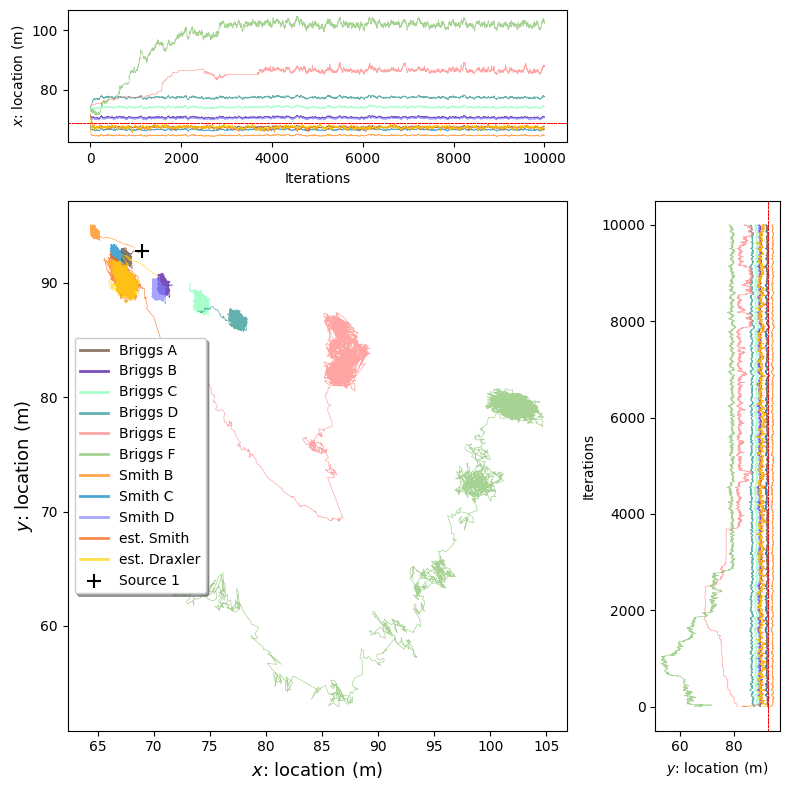

In [12]:
plot_source_location_estimates(0, source_1_mcmc_chains, source_location, False)

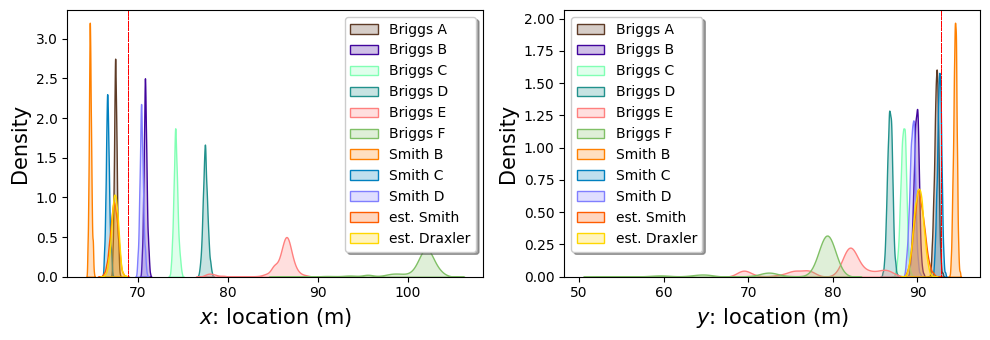

In [13]:
plot_source_location_densities(1_000, source_1_mcmc_chains, source_location, False)

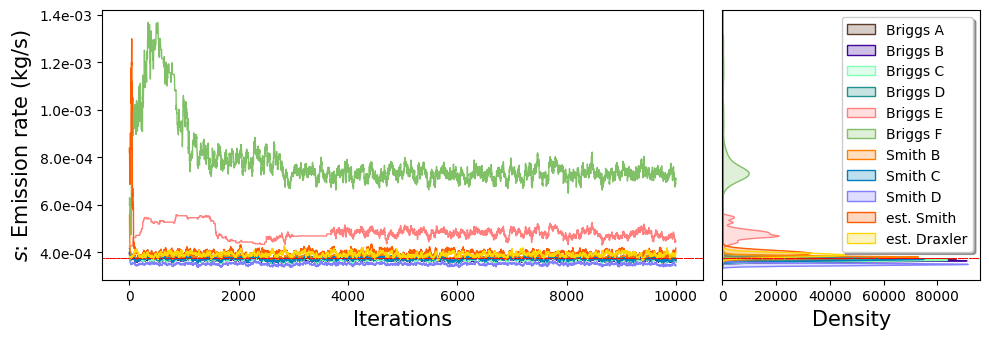

In [14]:
plot_source_emission_rate(0, source_1_mcmc_chains, atmospheric_state, False)

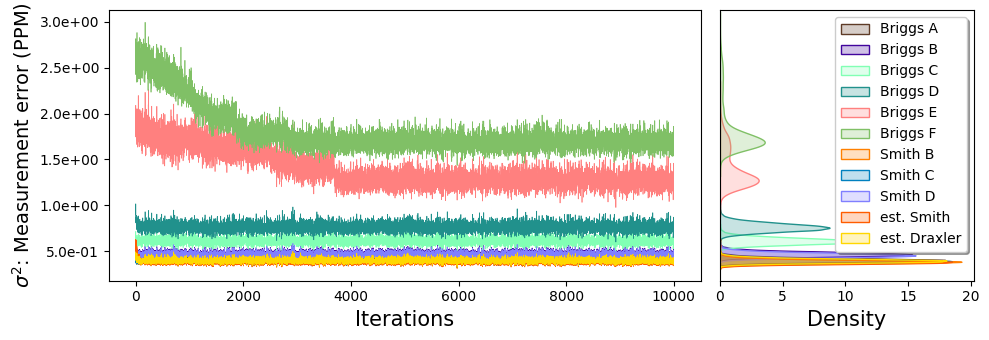

In [15]:
plot_sensor_measurement_error_variance(0, source_1_mcmc_chains, False)

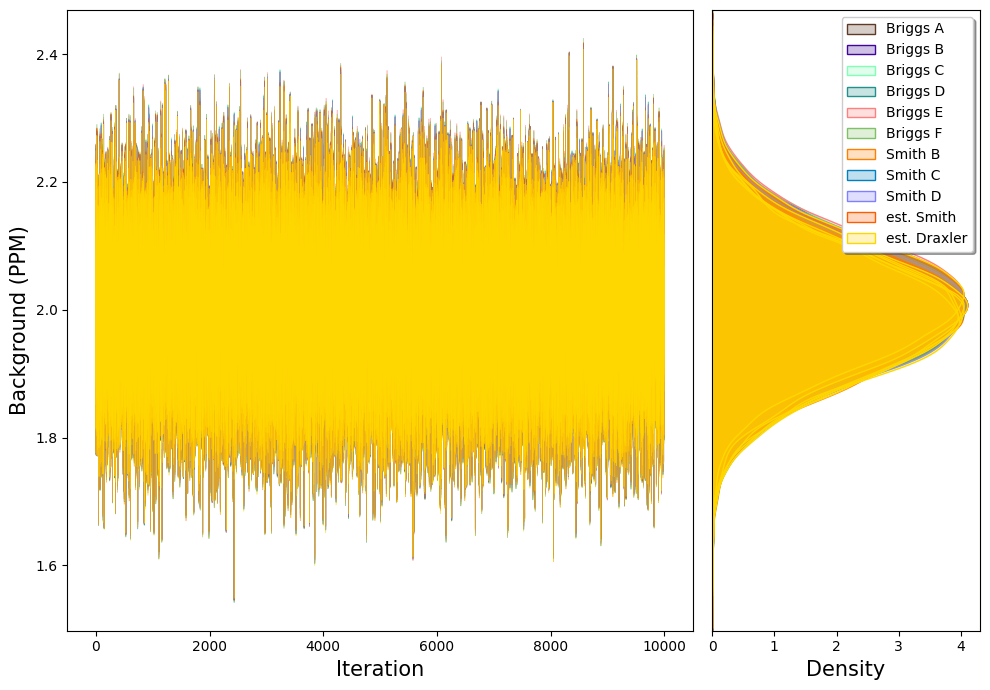

In [16]:
plot_background(0, source_1_mcmc_chains, False)

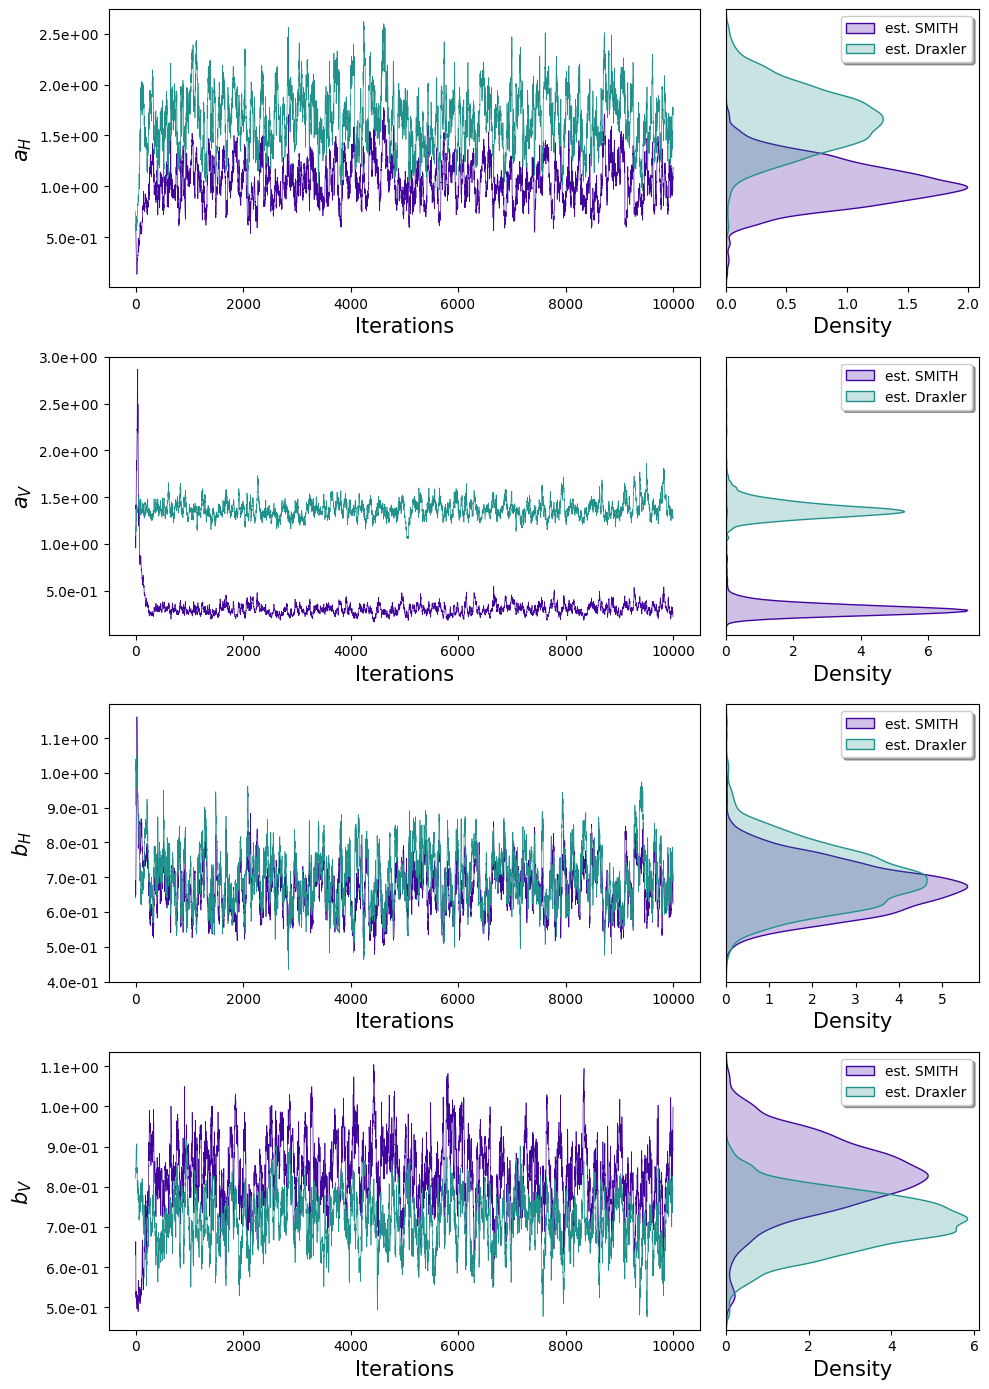

In [17]:
plot_dispersion_parameters(0, source_1_mcmc_chains_dp, False)

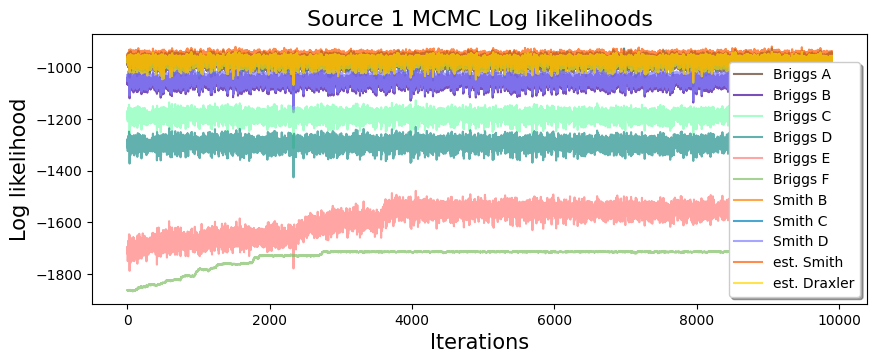

In [18]:
plot_log_likelihood(100, source_1_mcmc_chains, False)

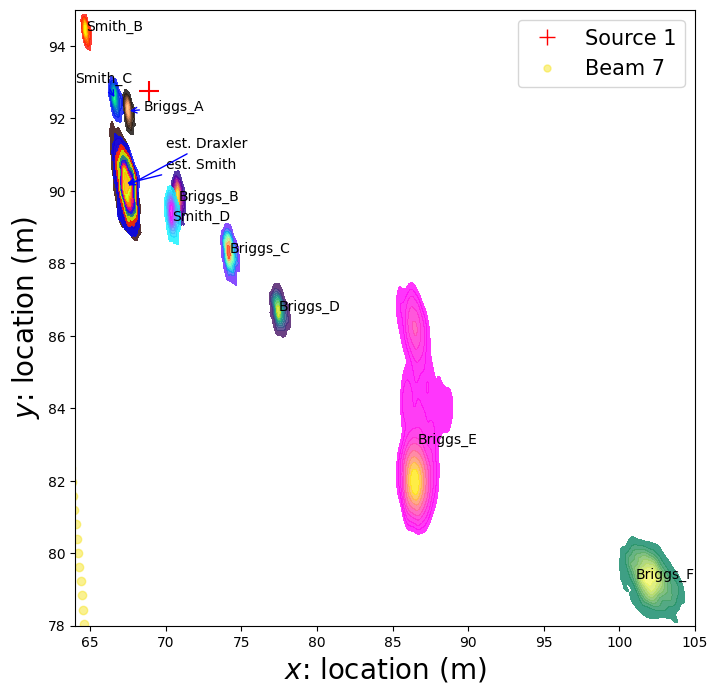

In [19]:
burn_in = 4_000
plt.figure(figsize=(8, 8))

# Briggs A
sns.kdeplot(x=Briggs_A["source_x"][burn_in:,0], y=Briggs_A["source_y"][burn_in:,0], cmap='copper', fill=True, alpha=0.8)
plt.annotate('Briggs_A', xy=(Briggs_A["source_x"][burn_in:,0].mean(), Briggs_A["source_y"][burn_in:,0].mean()), xytext=(Briggs_A["source_x"][burn_in:,0].mean()+1, Briggs_A["source_y"][burn_in:,0].mean()), arrowprops=dict(facecolor='red', edgecolor='blue', arrowstyle='->', linewidth=1, shrinkA=1, shrinkB=1))
# Briggs B
sns.kdeplot(x=Briggs_B["source_x"][burn_in:,0], y=Briggs_B["source_y"][burn_in:,0], cmap='plasma', fill=True, alpha=0.8)
plt.text(x=Briggs_B["source_x"][burn_in:,0].mean(), y=Briggs_B["source_y"][burn_in:,0].mean()-0.1, s='Briggs_B', color='black')
# Briggs C
sns.kdeplot(x=Briggs_C["source_x"][burn_in:,0], y=Briggs_C["source_y"][burn_in:,0], cmap='rainbow', fill=True, alpha=0.8)
plt.text(x=Briggs_C["source_x"][burn_in:,0].mean(), y=Briggs_C["source_y"][burn_in:,0].mean(), s='Briggs_C', color='black')
# Briggs D
sns.kdeplot(x=Briggs_D["source_x"][burn_in:,0], y=Briggs_D["source_y"][burn_in:,0], cmap='viridis', fill=True, alpha=0.8)
plt.text(x=Briggs_D["source_x"][burn_in:,0].mean(), y=Briggs_D["source_y"][burn_in:,0].mean(), s='Briggs_D', color='black')
# Briggs E
sns.kdeplot(x=Briggs_E["source_x"][burn_in:,0], y=Briggs_E["source_y"][burn_in:,0], cmap='spring', fill=True, alpha=0.8)
plt.text(x=Briggs_E["source_x"][burn_in:,0].mean(), y=Briggs_E["source_y"][burn_in:,0].mean(), s='Briggs_E', color='black')
# Briggs F
sns.kdeplot(x=Briggs_F["source_x"][burn_in:,0], y=Briggs_F["source_y"][burn_in:,0], cmap='summer', fill=True, alpha=0.8)
plt.text(x=Briggs_F["source_x"][burn_in:,0].mean()-1, y=Briggs_F["source_y"][burn_in:,0].mean(), s='Briggs_F', color='black')
# SMITH B
sns.kdeplot(x=SMITH_B["source_x"][burn_in:,0], y=SMITH_B["source_y"][burn_in:,0], cmap='autumn', fill=True, alpha=0.8)
plt.text(x=SMITH_B["source_x"][burn_in:,0].mean(), y=SMITH_B["source_y"][burn_in:,0].mean(), s='Smith_B', color='black')
# SMITH C
sns.kdeplot(x=SMITH_C["source_x"][burn_in:,0], y=SMITH_C["source_y"][burn_in:,0], cmap='winter', fill=True, alpha=0.8)
plt.annotate('Smith_C', xy=(SMITH_C["source_x"][burn_in:,0].mean(), SMITH_C["source_y"][burn_in:,0].mean()), xytext=(64, 93), arrowprops=dict(facecolor='red', edgecolor='blue', arrowstyle='->', linewidth=1, shrinkA=1, shrinkB=1))
# SMITH D
sns.kdeplot(x=SMITH_D["source_x"][burn_in:,0], y=SMITH_D["source_y"][burn_in:,0], cmap='cool', fill=True, alpha=0.8)
plt.text(x=SMITH_D["source_x"][burn_in:,0].mean(), y=SMITH_D["source_y"][burn_in:,0].mean()-0.2, s='Smith_D', color='black')
# Estimated SMITH
sns.kdeplot(x=est_SMITH["source_x"][burn_in:,0], y=est_SMITH["source_y"][burn_in:,0], cmap='hot', fill=True, alpha=0.8)
plt.annotate('est. Smith', xy=(est_SMITH["source_x"][burn_in:,0].mean(), est_SMITH["source_y"][burn_in:,0].mean()), xytext=(70, 90.6), arrowprops=dict(facecolor='red', edgecolor='blue', arrowstyle='->', linewidth=1, shrinkA=1, shrinkB=1))
# Estimated Draxler
sns.kdeplot(x=est_Draxler["source_x"][burn_in:,0], y=est_Draxler["source_y"][burn_in:,0], cmap='prism', fill=True, alpha=0.8)
plt.annotate('est. Draxler', xy=(est_Draxler["source_x"][burn_in:,0].mean(), est_Draxler["source_y"][burn_in:,0].mean()), xytext=(70, 91.2), arrowprops=dict(facecolor='red', edgecolor='blue', arrowstyle='->', linewidth=1, shrinkA=1, shrinkB=1))

# Sources
plt.scatter(sources["source_1_location"][0], sources["source_1_location"][1], color='red', marker='+', label='Source 1', s=200)
plt.scatter(sources["source_2_location"][0], sources["source_2_location"][1], color='black', marker='x', label='Source 2', alpha=0.2, s=80)
plt.scatter(sources["source_3_location"][0], sources["source_3_location"][1], color='black', marker='o', label='Source 3', alpha=0.2, s=80)
plt.scatter(sources["source_4_location"][0], sources["source_4_location"][1], color='black', marker='*', label='Source 4', alpha=0.2, s=80)
plt.scatter(60, 100, color='lightcoral', marker='.')
colors = cm.plasma(np.linspace(0, 0.95, 7))

# Extract x, y, z coordinates
x_coords_1 = [location[0] for location in point_sensors_1_location]
y_coords_1 = [location[1] for location in point_sensors_1_location]

x_coords_2 = [location[0] for location in point_sensors_2_location]
y_coords_2 = [location[1] for location in point_sensors_2_location]

x_coords_3 = [location[0] for location in point_sensors_3_location]
y_coords_3 = [location[1] for location in point_sensors_3_location]

x_coords_4 = [location[0] for location in point_sensors_4_location]
y_coords_4 = [location[1] for location in point_sensors_4_location]

x_coords_5 = [location[0] for location in point_sensors_5_location]
y_coords_5 = [location[1] for location in point_sensors_5_location]

x_coords_6 = [location[0] for location in point_sensors_6_location]
y_coords_6 = [location[1] for location in point_sensors_6_location]

x_coords_7 = [location[0] for location in point_sensors_7_location]
y_coords_7 = [location[1] for location in point_sensors_7_location]


# Plot the sensor locations
plt.scatter(x_coords_1, y_coords_1, alpha=0.5, color=colors[0])
plt.scatter(x_coords_2, y_coords_2, alpha=0.5, color=colors[1])
plt.scatter(x_coords_3, y_coords_3, alpha=0.5, color=colors[2])
plt.scatter(x_coords_4, y_coords_4, alpha=0.5, color=colors[3])
plt.scatter(x_coords_5, y_coords_5, alpha=0.5, color=colors[4])
plt.scatter(x_coords_6, y_coords_6, alpha=0.5, color=colors[5])
plt.scatter(x_coords_7, y_coords_7, alpha=0.5, color=colors[6])
plt.xlabel("$x$: location (m)", fontsize=20)
plt.ylabel("$y$: location (m)", fontsize=20)
plt.xlim(64, 105)
plt.ylim(78, 95)
plt.legend()
legend_elements = [ plt.Line2D([0], [0], marker='+', color='red', label='Source 1', markersize=12, linestyle='None'),
                    plt.Line2D([0], [0], marker='.', color=colors[6], label='Beam 7', markersize=10, linestyle='None', alpha=0.5)]

plt.legend(handles=legend_elements, loc='upper right', fontsize=15)
# plt.savefig('2d_density_sensor_and_source1_location.png', dpi=300, bbox_inches='tight')
plt.show()

### 2.3 Computing model BIC

In [20]:
num_observations = observations_src1.shape[0]

burn_in = 4_000

bic_estimated = calculate_bic(burn_in, est_Draxler, 15, num_observations)
bic_smith_B = calculate_bic(burn_in, SMITH_B, 11, num_observations)
bic_smith_C = calculate_bic(burn_in, SMITH_C, 11, num_observations)
bic_smith_D = calculate_bic(burn_in, SMITH_D, 11, num_observations)
bic_briggs_A = calculate_bic(burn_in, Briggs_A, 11, num_observations)
bic_briggs_B = calculate_bic(burn_in, Briggs_B, 11, num_observations)
bic_briggs_C = calculate_bic(burn_in, Briggs_C, 11, num_observations)
bic_briggs_D = calculate_bic(burn_in, Briggs_D, 11, num_observations)
bic_briggs_E = calculate_bic(burn_in, Briggs_E, 11, num_observations)
bic_briggs_F = calculate_bic(burn_in, Briggs_F, 11, num_observations)
bic_est_SMITH = calculate_bic(burn_in, est_SMITH, 15, num_observations)

print(f'BIC of the different wind sigma parametrization schemes')
print(f'-------------------------------------------------------')
print(f"BIC estimated: {bic_estimated}")
print(f"BIC SMITH B: {bic_smith_B}")
print(f"BIC SMITH C: {bic_smith_C}")
print(f"BIC SMITH D: {bic_smith_D}")
print(f"BIC Briggs A: {bic_briggs_A}")
print(f"BIC Briggs B: {bic_briggs_B}")
print(f"BIC Briggs C: {bic_briggs_C}")
print(f"BIC Briggs D: {bic_briggs_D}")
print(f"BIC Briggs E: {bic_briggs_E}")
print(f"BIC Briggs F: {bic_briggs_F}")
print(f"BIC est_SMITH: {bic_est_SMITH}")
print(f'-------------------------------------------------------')


BIC of the different wind sigma parametrization schemes
-------------------------------------------------------
BIC estimated: 2058.165584329323
BIC SMITH B: 2014.1031546202632
BIC SMITH C: 2021.0398483010279
BIC SMITH D: 2166.6467623843305
BIC Briggs A: 2047.7813096414432
BIC Briggs B: 2188.891422606923
BIC Briggs C: 2450.2890264059056
BIC Briggs D: 2666.9979744624093
BIC Briggs E: 3180.6299237240382
BIC Briggs F: 3502.0685037531002
BIC est_SMITH: 2025.3956078556992
-------------------------------------------------------


### 2.4 Data vs Model predictions: RMSE of Temporal Prediction
Here we compare the time series dataset collected by the different beams to the models' predictions.

In [21]:
burn_in = 4_000


# Briggs_A
MAP_Briggs_A ={
    "source_x": jnp.mean(Briggs_A["source_x"][burn_in:]),
    "source_y": jnp.mean(Briggs_A["source_y"][burn_in:]),
    "s": jnp.mean(Briggs_A["s"][burn_in:]),
    "sigma_squared": jnp.mean(Briggs_A["sigma_squared"][burn_in:]),
    "background": jnp.mean(Briggs_A["background"][burn_in:], axis=0),
}
x, y = MAP_Briggs_A["source_x"], MAP_Briggs_A["source_y"]
coupling_matrix_ref1 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref1_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="A")
coupling_matrix_ref2 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref2_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="A")
coupling_matrix_ref3 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref3_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="A")
coupling_matrix_ref4 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref4_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="A")
coupling_matrix_ref5 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref5_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="A")
coupling_matrix_ref6 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref6_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="A")
coupling_matrix_ref7 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref7_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="A")
reshaped_coupling_matrix_ref1 = coupling_matrix_ref1.reshape(wind_field_src1.shape[0],18*5, order='F')
reshaped_coupling_matrix_ref2 = coupling_matrix_ref2.reshape(wind_field_src1.shape[0],33*5, order='F')
reshaped_coupling_matrix_ref3 = coupling_matrix_ref3.reshape(wind_field_src1.shape[0],22*5, order='F')
reshaped_coupling_matrix_ref4 = coupling_matrix_ref4.reshape(wind_field_src1.shape[0],49*5, order='F')
reshaped_coupling_matrix_ref5 = coupling_matrix_ref5.reshape(wind_field_src1.shape[0],42*5, order='F')
reshaped_coupling_matrix_ref6 = coupling_matrix_ref6.reshape(wind_field_src1.shape[0],29*5, order='F')
reshaped_coupling_matrix_ref7 = coupling_matrix_ref7.reshape(wind_field_src1.shape[0],17*5, order='F')
path_averaged_coupling_matrix_ref1 = reshaped_coupling_matrix_ref1.mean(axis=1)
path_averaged_coupling_matrix_ref2 = reshaped_coupling_matrix_ref2.mean(axis=1)
path_averaged_coupling_matrix_ref3 = reshaped_coupling_matrix_ref3.mean(axis=1)
path_averaged_coupling_matrix_ref4 = reshaped_coupling_matrix_ref4.mean(axis=1)
path_averaged_coupling_matrix_ref5 = reshaped_coupling_matrix_ref5.mean(axis=1)
path_averaged_coupling_matrix_ref6 = reshaped_coupling_matrix_ref6.mean(axis=1)
path_averaged_coupling_matrix_ref7 = reshaped_coupling_matrix_ref7.mean(axis=1)
path_averaged_A = [path_averaged_coupling_matrix_ref1, path_averaged_coupling_matrix_ref2, path_averaged_coupling_matrix_ref3, path_averaged_coupling_matrix_ref4, path_averaged_coupling_matrix_ref5, path_averaged_coupling_matrix_ref6, path_averaged_coupling_matrix_ref7]
A_Briggs_A = jnp.array(path_averaged_A).reshape(-1,1)


# Briggs_B
MAP_Briggs_B ={
    "source_x": jnp.mean(Briggs_B["source_x"][burn_in:]),
    "source_y": jnp.mean(Briggs_B["source_y"][burn_in:]),
    "s": jnp.mean(Briggs_B["s"][burn_in:]),
    "sigma_squared": jnp.mean(Briggs_B["sigma_squared"][burn_in:]),
    "background": jnp.mean(Briggs_B["background"][burn_in:], axis=0),
}
x, y = MAP_Briggs_B["source_x"], MAP_Briggs_B["source_y"]
coupling_matrix_ref1 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref1_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="B")
coupling_matrix_ref2 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref2_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="B")
coupling_matrix_ref3 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref3_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="B")
coupling_matrix_ref4 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref4_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="B")
coupling_matrix_ref5 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref5_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="B")
coupling_matrix_ref6 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref6_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="B")
coupling_matrix_ref7 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref7_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="B")
reshaped_coupling_matrix_ref1 = coupling_matrix_ref1.reshape(wind_field_src1.shape[0],18*5, order='F')
reshaped_coupling_matrix_ref2 = coupling_matrix_ref2.reshape(wind_field_src1.shape[0],33*5, order='F')
reshaped_coupling_matrix_ref3 = coupling_matrix_ref3.reshape(wind_field_src1.shape[0],22*5, order='F')
reshaped_coupling_matrix_ref4 = coupling_matrix_ref4.reshape(wind_field_src1.shape[0],49*5, order='F')
reshaped_coupling_matrix_ref5 = coupling_matrix_ref5.reshape(wind_field_src1.shape[0],42*5, order='F')
reshaped_coupling_matrix_ref6 = coupling_matrix_ref6.reshape(wind_field_src1.shape[0],29*5, order='F')
reshaped_coupling_matrix_ref7 = coupling_matrix_ref7.reshape(wind_field_src1.shape[0],17*5, order='F')
path_averaged_coupling_matrix_ref1 = reshaped_coupling_matrix_ref1.mean(axis=1)
path_averaged_coupling_matrix_ref2 = reshaped_coupling_matrix_ref2.mean(axis=1)
path_averaged_coupling_matrix_ref3 = reshaped_coupling_matrix_ref3.mean(axis=1)
path_averaged_coupling_matrix_ref4 = reshaped_coupling_matrix_ref4.mean(axis=1)
path_averaged_coupling_matrix_ref5 = reshaped_coupling_matrix_ref5.mean(axis=1)
path_averaged_coupling_matrix_ref6 = reshaped_coupling_matrix_ref6.mean(axis=1)
path_averaged_coupling_matrix_ref7 = reshaped_coupling_matrix_ref7.mean(axis=1)
path_averaged_A = [path_averaged_coupling_matrix_ref1, path_averaged_coupling_matrix_ref2, path_averaged_coupling_matrix_ref3, path_averaged_coupling_matrix_ref4, path_averaged_coupling_matrix_ref5, path_averaged_coupling_matrix_ref6, path_averaged_coupling_matrix_ref7]
A_Briggs_B = jnp.array(path_averaged_A).reshape(-1,1)


# Briggs_C
MAP_Briggs_C ={
    "source_x": jnp.mean(Briggs_C["source_x"][burn_in:]),
    "source_y": jnp.mean(Briggs_C["source_y"][burn_in:]),
    "s": jnp.mean(Briggs_C["s"][burn_in:]),
    "sigma_squared": jnp.mean(Briggs_C["sigma_squared"][burn_in:]),
    "background": jnp.mean(Briggs_C["background"][burn_in:], axis=0),
}
x, y = MAP_Briggs_C["source_x"], MAP_Briggs_C["source_y"]
coupling_matrix_ref1 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref1_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="C")
coupling_matrix_ref2 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref2_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="C")
coupling_matrix_ref3 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref3_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="C")
coupling_matrix_ref4 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref4_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="C")
coupling_matrix_ref5 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref5_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="C")
coupling_matrix_ref6 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref6_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="C")
coupling_matrix_ref7 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref7_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="C")
reshaped_coupling_matrix_ref1 = coupling_matrix_ref1.reshape(wind_field_src1.shape[0],18*5, order='F')
reshaped_coupling_matrix_ref2 = coupling_matrix_ref2.reshape(wind_field_src1.shape[0],33*5, order='F')
reshaped_coupling_matrix_ref3 = coupling_matrix_ref3.reshape(wind_field_src1.shape[0],22*5, order='F')
reshaped_coupling_matrix_ref4 = coupling_matrix_ref4.reshape(wind_field_src1.shape[0],49*5, order='F')
reshaped_coupling_matrix_ref5 = coupling_matrix_ref5.reshape(wind_field_src1.shape[0],42*5, order='F')
reshaped_coupling_matrix_ref6 = coupling_matrix_ref6.reshape(wind_field_src1.shape[0],29*5, order='F')
reshaped_coupling_matrix_ref7 = coupling_matrix_ref7.reshape(wind_field_src1.shape[0],17*5, order='F')
path_averaged_coupling_matrix_ref1 = reshaped_coupling_matrix_ref1.mean(axis=1)
path_averaged_coupling_matrix_ref2 = reshaped_coupling_matrix_ref2.mean(axis=1)
path_averaged_coupling_matrix_ref3 = reshaped_coupling_matrix_ref3.mean(axis=1)
path_averaged_coupling_matrix_ref4 = reshaped_coupling_matrix_ref4.mean(axis=1)
path_averaged_coupling_matrix_ref5 = reshaped_coupling_matrix_ref5.mean(axis=1)
path_averaged_coupling_matrix_ref6 = reshaped_coupling_matrix_ref6.mean(axis=1)
path_averaged_coupling_matrix_ref7 = reshaped_coupling_matrix_ref7.mean(axis=1)
path_averaged_A = [path_averaged_coupling_matrix_ref1, path_averaged_coupling_matrix_ref2, path_averaged_coupling_matrix_ref3, path_averaged_coupling_matrix_ref4, path_averaged_coupling_matrix_ref5, path_averaged_coupling_matrix_ref6, path_averaged_coupling_matrix_ref7]
A_Briggs_C = jnp.array(path_averaged_A).reshape(-1,1)


# Briggs D
MAP_Briggs_D ={
    "source_x": jnp.mean(Briggs_D["source_x"][burn_in:]),
    "source_y": jnp.mean(Briggs_D["source_y"][burn_in:]),
    "s": jnp.mean(Briggs_D["s"][burn_in:]),
    "sigma_squared": jnp.mean(Briggs_D["sigma_squared"][burn_in:]),
    "background": jnp.mean(Briggs_D["background"][burn_in:], axis=0),
}
x, y = MAP_Briggs_D["source_x"], MAP_Briggs_D["source_y"]
coupling_matrix_ref1 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref1_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="D")
coupling_matrix_ref2 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref2_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="D")
coupling_matrix_ref3 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref3_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="D")
coupling_matrix_ref4 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref4_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="D")
coupling_matrix_ref5 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref5_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="D")
coupling_matrix_ref6 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref6_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="D")
coupling_matrix_ref7 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref7_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="D")
reshaped_coupling_matrix_ref1 = coupling_matrix_ref1.reshape(wind_field_src1.shape[0],18*5, order='F')
reshaped_coupling_matrix_ref2 = coupling_matrix_ref2.reshape(wind_field_src1.shape[0],33*5, order='F')
reshaped_coupling_matrix_ref3 = coupling_matrix_ref3.reshape(wind_field_src1.shape[0],22*5, order='F')
reshaped_coupling_matrix_ref4 = coupling_matrix_ref4.reshape(wind_field_src1.shape[0],49*5, order='F')
reshaped_coupling_matrix_ref5 = coupling_matrix_ref5.reshape(wind_field_src1.shape[0],42*5, order='F')
reshaped_coupling_matrix_ref6 = coupling_matrix_ref6.reshape(wind_field_src1.shape[0],29*5, order='F')
reshaped_coupling_matrix_ref7 = coupling_matrix_ref7.reshape(wind_field_src1.shape[0],17*5, order='F')
path_averaged_coupling_matrix_ref1 = reshaped_coupling_matrix_ref1.mean(axis=1)
path_averaged_coupling_matrix_ref2 = reshaped_coupling_matrix_ref2.mean(axis=1)
path_averaged_coupling_matrix_ref3 = reshaped_coupling_matrix_ref3.mean(axis=1)
path_averaged_coupling_matrix_ref4 = reshaped_coupling_matrix_ref4.mean(axis=1)
path_averaged_coupling_matrix_ref5 = reshaped_coupling_matrix_ref5.mean(axis=1)
path_averaged_coupling_matrix_ref6 = reshaped_coupling_matrix_ref6.mean(axis=1)
path_averaged_coupling_matrix_ref7 = reshaped_coupling_matrix_ref7.mean(axis=1)
path_averaged_A = [path_averaged_coupling_matrix_ref1, path_averaged_coupling_matrix_ref2, path_averaged_coupling_matrix_ref3, path_averaged_coupling_matrix_ref4, path_averaged_coupling_matrix_ref5, path_averaged_coupling_matrix_ref6, path_averaged_coupling_matrix_ref7]
A_Briggs_D = jnp.array(path_averaged_A).reshape(-1,1)


# Briggs E
MAP_Briggs_E ={
    "source_x": jnp.mean(Briggs_E["source_x"][burn_in:]),
    "source_y": jnp.mean(Briggs_E["source_y"][burn_in:]),
    "s": jnp.mean(Briggs_E["s"][burn_in:]),
    "sigma_squared": jnp.mean(Briggs_E["sigma_squared"][burn_in:]),
    "background": jnp.mean(Briggs_E["background"][burn_in:], axis=0),
}
x, y = MAP_Briggs_E["source_x"], MAP_Briggs_E["source_y"]
coupling_matrix_ref1 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref1_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="E")
coupling_matrix_ref2 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref2_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="E")
coupling_matrix_ref3 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref3_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="E")
coupling_matrix_ref4 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref4_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="E")
coupling_matrix_ref5 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref5_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="E")
coupling_matrix_ref6 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref6_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="E")
coupling_matrix_ref7 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref7_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="E")
reshaped_coupling_matrix_ref1 = coupling_matrix_ref1.reshape(wind_field_src1.shape[0],18*5, order='F')
reshaped_coupling_matrix_ref2 = coupling_matrix_ref2.reshape(wind_field_src1.shape[0],33*5, order='F')
reshaped_coupling_matrix_ref3 = coupling_matrix_ref3.reshape(wind_field_src1.shape[0],22*5, order='F')
reshaped_coupling_matrix_ref4 = coupling_matrix_ref4.reshape(wind_field_src1.shape[0],49*5, order='F')
reshaped_coupling_matrix_ref5 = coupling_matrix_ref5.reshape(wind_field_src1.shape[0],42*5, order='F')
reshaped_coupling_matrix_ref6 = coupling_matrix_ref6.reshape(wind_field_src1.shape[0],29*5, order='F')
reshaped_coupling_matrix_ref7 = coupling_matrix_ref7.reshape(wind_field_src1.shape[0],17*5, order='F')
path_averaged_coupling_matrix_ref1 = reshaped_coupling_matrix_ref1.mean(axis=1)
path_averaged_coupling_matrix_ref2 = reshaped_coupling_matrix_ref2.mean(axis=1)
path_averaged_coupling_matrix_ref3 = reshaped_coupling_matrix_ref3.mean(axis=1)
path_averaged_coupling_matrix_ref4 = reshaped_coupling_matrix_ref4.mean(axis=1)
path_averaged_coupling_matrix_ref5 = reshaped_coupling_matrix_ref5.mean(axis=1)
path_averaged_coupling_matrix_ref6 = reshaped_coupling_matrix_ref6.mean(axis=1)
path_averaged_coupling_matrix_ref7 = reshaped_coupling_matrix_ref7.mean(axis=1)
path_averaged_A = [path_averaged_coupling_matrix_ref1, path_averaged_coupling_matrix_ref2, path_averaged_coupling_matrix_ref3, path_averaged_coupling_matrix_ref4, path_averaged_coupling_matrix_ref5, path_averaged_coupling_matrix_ref6, path_averaged_coupling_matrix_ref7]
A_Briggs_E = jnp.array(path_averaged_A).reshape(-1,1)


# Briggs F
MAP_Briggs_F ={
    "source_x": jnp.mean(Briggs_F["source_x"][burn_in:]),
    "source_y": jnp.mean(Briggs_F["source_y"][burn_in:]),
    "s": jnp.mean(Briggs_F["s"][burn_in:]),
    "sigma_squared": jnp.mean(Briggs_F["sigma_squared"][burn_in:]),
    "background": jnp.mean(Briggs_F["background"][burn_in:], axis=0),
}
x, y = MAP_Briggs_F["source_x"], MAP_Briggs_F["source_y"]
coupling_matrix_ref1 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref1_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="F")
coupling_matrix_ref2 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref2_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="F")
coupling_matrix_ref3 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref3_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="F")
coupling_matrix_ref4 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref4_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="F")
coupling_matrix_ref5 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref5_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="F")
coupling_matrix_ref6 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref6_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="F")
coupling_matrix_ref7 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref7_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="F")
reshaped_coupling_matrix_ref1 = coupling_matrix_ref1.reshape(wind_field_src1.shape[0],18*5, order='F')
reshaped_coupling_matrix_ref2 = coupling_matrix_ref2.reshape(wind_field_src1.shape[0],33*5, order='F')
reshaped_coupling_matrix_ref3 = coupling_matrix_ref3.reshape(wind_field_src1.shape[0],22*5, order='F')
reshaped_coupling_matrix_ref4 = coupling_matrix_ref4.reshape(wind_field_src1.shape[0],49*5, order='F')
reshaped_coupling_matrix_ref5 = coupling_matrix_ref5.reshape(wind_field_src1.shape[0],42*5, order='F')
reshaped_coupling_matrix_ref6 = coupling_matrix_ref6.reshape(wind_field_src1.shape[0],29*5, order='F')
reshaped_coupling_matrix_ref7 = coupling_matrix_ref7.reshape(wind_field_src1.shape[0],17*5, order='F')
path_averaged_coupling_matrix_ref1 = reshaped_coupling_matrix_ref1.mean(axis=1)
path_averaged_coupling_matrix_ref2 = reshaped_coupling_matrix_ref2.mean(axis=1)
path_averaged_coupling_matrix_ref3 = reshaped_coupling_matrix_ref3.mean(axis=1)
path_averaged_coupling_matrix_ref4 = reshaped_coupling_matrix_ref4.mean(axis=1)
path_averaged_coupling_matrix_ref5 = reshaped_coupling_matrix_ref5.mean(axis=1)
path_averaged_coupling_matrix_ref6 = reshaped_coupling_matrix_ref6.mean(axis=1)
path_averaged_coupling_matrix_ref7 = reshaped_coupling_matrix_ref7.mean(axis=1)
path_averaged_A = [path_averaged_coupling_matrix_ref1, path_averaged_coupling_matrix_ref2, path_averaged_coupling_matrix_ref3, path_averaged_coupling_matrix_ref4, path_averaged_coupling_matrix_ref5, path_averaged_coupling_matrix_ref6, path_averaged_coupling_matrix_ref7]
A_Briggs_F = jnp.array(path_averaged_A).reshape(-1,1)


# Smith B
MAP_SMITH_B ={
    "source_x": jnp.mean(SMITH_B["source_x"][burn_in:]),
    "source_y": jnp.mean(SMITH_B["source_y"][burn_in:]),
    "s": jnp.mean(SMITH_B["s"][burn_in:]),
    "sigma_squared": jnp.mean(SMITH_B["sigma_squared"][burn_in:]),
    "background": jnp.mean(SMITH_B["background"][burn_in:], axis=0),
}
x, y = MAP_SMITH_B["source_x"], MAP_SMITH_B["source_y"]
coupling_matrix_ref1 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref1_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="SMITH")
coupling_matrix_ref2 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref2_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="SMITH")
coupling_matrix_ref3 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref3_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="SMITH")
coupling_matrix_ref4 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref4_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="SMITH")    
coupling_matrix_ref5 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref5_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="SMITH")
coupling_matrix_ref6 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref6_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="SMITH")
coupling_matrix_ref7 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref7_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="SMITH")
reshaped_coupling_matrix_ref1 = coupling_matrix_ref1.reshape(wind_field_src1.shape[0],18*5, order='F')
reshaped_coupling_matrix_ref2 = coupling_matrix_ref2.reshape(wind_field_src1.shape[0],33*5, order='F')
reshaped_coupling_matrix_ref3 = coupling_matrix_ref3.reshape(wind_field_src1.shape[0],22*5, order='F')
reshaped_coupling_matrix_ref4 = coupling_matrix_ref4.reshape(wind_field_src1.shape[0],49*5, order='F')
reshaped_coupling_matrix_ref5 = coupling_matrix_ref5.reshape(wind_field_src1.shape[0],42*5, order='F')
reshaped_coupling_matrix_ref6 = coupling_matrix_ref6.reshape(wind_field_src1.shape[0],29*5, order='F')
reshaped_coupling_matrix_ref7 = coupling_matrix_ref7.reshape(wind_field_src1.shape[0],17*5, order='F')
path_averaged_coupling_matrix_ref1 = reshaped_coupling_matrix_ref1.mean(axis=1)
path_averaged_coupling_matrix_ref2 = reshaped_coupling_matrix_ref2.mean(axis=1)
path_averaged_coupling_matrix_ref3 = reshaped_coupling_matrix_ref3.mean(axis=1)
path_averaged_coupling_matrix_ref4 = reshaped_coupling_matrix_ref4.mean(axis=1)
path_averaged_coupling_matrix_ref5 = reshaped_coupling_matrix_ref5.mean(axis=1)
path_averaged_coupling_matrix_ref6 = reshaped_coupling_matrix_ref6.mean(axis=1)
path_averaged_coupling_matrix_ref7 = reshaped_coupling_matrix_ref7.mean(axis=1)
path_averaged_A = [path_averaged_coupling_matrix_ref1, path_averaged_coupling_matrix_ref2, path_averaged_coupling_matrix_ref3, path_averaged_coupling_matrix_ref4, path_averaged_coupling_matrix_ref5, path_averaged_coupling_matrix_ref6, path_averaged_coupling_matrix_ref7]
A_SMITH_B = jnp.array(path_averaged_A).reshape(-1,1)


# Smith C
MAP_SMITH_C ={
    "source_x": jnp.mean(SMITH_C["source_x"][burn_in:]),
    "source_y": jnp.mean(SMITH_C["source_y"][burn_in:]),
    "s": jnp.mean(SMITH_C["s"][burn_in:]),
    "sigma_squared": jnp.mean(SMITH_C["sigma_squared"][burn_in:]),
    "background": jnp.mean(SMITH_C["background"][burn_in:], axis=0),
}
x, y = MAP_SMITH_C["source_x"], MAP_SMITH_C["source_y"]
coupling_matrix_ref1 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref1_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="SMITH")
coupling_matrix_ref2 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref2_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="SMITH")
coupling_matrix_ref3 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref3_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="SMITH")
coupling_matrix_ref4 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref4_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="SMITH")    
coupling_matrix_ref5 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref5_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="SMITH")
coupling_matrix_ref6 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref6_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="SMITH")
coupling_matrix_ref7 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref7_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="SMITH")
reshaped_coupling_matrix_ref1 = coupling_matrix_ref1.reshape(wind_field_src1.shape[0],18*5, order='F')
reshaped_coupling_matrix_ref2 = coupling_matrix_ref2.reshape(wind_field_src1.shape[0],33*5, order='F')
reshaped_coupling_matrix_ref3 = coupling_matrix_ref3.reshape(wind_field_src1.shape[0],22*5, order='F')
reshaped_coupling_matrix_ref4 = coupling_matrix_ref4.reshape(wind_field_src1.shape[0],49*5, order='F')
reshaped_coupling_matrix_ref5 = coupling_matrix_ref5.reshape(wind_field_src1.shape[0],42*5, order='F')
reshaped_coupling_matrix_ref6 = coupling_matrix_ref6.reshape(wind_field_src1.shape[0],29*5, order='F')
reshaped_coupling_matrix_ref7 = coupling_matrix_ref7.reshape(wind_field_src1.shape[0],17*5, order='F')
path_averaged_coupling_matrix_ref1 = reshaped_coupling_matrix_ref1.mean(axis=1)
path_averaged_coupling_matrix_ref2 = reshaped_coupling_matrix_ref2.mean(axis=1)
path_averaged_coupling_matrix_ref3 = reshaped_coupling_matrix_ref3.mean(axis=1)
path_averaged_coupling_matrix_ref4 = reshaped_coupling_matrix_ref4.mean(axis=1)
path_averaged_coupling_matrix_ref5 = reshaped_coupling_matrix_ref5.mean(axis=1)
path_averaged_coupling_matrix_ref6 = reshaped_coupling_matrix_ref6.mean(axis=1)
path_averaged_coupling_matrix_ref7 = reshaped_coupling_matrix_ref7.mean(axis=1)
path_averaged_A = [path_averaged_coupling_matrix_ref1, path_averaged_coupling_matrix_ref2, path_averaged_coupling_matrix_ref3, path_averaged_coupling_matrix_ref4, path_averaged_coupling_matrix_ref5, path_averaged_coupling_matrix_ref6, path_averaged_coupling_matrix_ref7]
A_SMITH_C = jnp.array(path_averaged_A).reshape(-1,1)


# Smith D
MAP_SMITH_D ={
    "source_x": jnp.mean(SMITH_D["source_x"][burn_in:]),
    "source_y": jnp.mean(SMITH_D["source_y"][burn_in:]),
    "s": jnp.mean(SMITH_D["s"][burn_in:]),
    "sigma_squared": jnp.mean(SMITH_D["sigma_squared"][burn_in:]),
    "background": jnp.mean(SMITH_D["background"][burn_in:], axis=0),
}
x, y = MAP_SMITH_D["source_x"], MAP_SMITH_D["source_y"]
coupling_matrix_ref1 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref1_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="SMITH")
coupling_matrix_ref2 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref2_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="SMITH")
coupling_matrix_ref3 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref3_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="SMITH")
coupling_matrix_ref4 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref4_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="SMITH")    
coupling_matrix_ref5 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref5_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="SMITH")
coupling_matrix_ref6 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref6_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="SMITH")
coupling_matrix_ref7 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref7_src1, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="SMITH")
reshaped_coupling_matrix_ref1 = coupling_matrix_ref1.reshape(wind_field_src1.shape[0],18*5, order='F')
reshaped_coupling_matrix_ref2 = coupling_matrix_ref2.reshape(wind_field_src1.shape[0],33*5, order='F')
reshaped_coupling_matrix_ref3 = coupling_matrix_ref3.reshape(wind_field_src1.shape[0],22*5, order='F')
reshaped_coupling_matrix_ref4 = coupling_matrix_ref4.reshape(wind_field_src1.shape[0],49*5, order='F')
reshaped_coupling_matrix_ref5 = coupling_matrix_ref5.reshape(wind_field_src1.shape[0],42*5, order='F')
reshaped_coupling_matrix_ref6 = coupling_matrix_ref6.reshape(wind_field_src1.shape[0],29*5, order='F')
reshaped_coupling_matrix_ref7 = coupling_matrix_ref7.reshape(wind_field_src1.shape[0],17*5, order='F')
path_averaged_coupling_matrix_ref1 = reshaped_coupling_matrix_ref1.mean(axis=1)
path_averaged_coupling_matrix_ref2 = reshaped_coupling_matrix_ref2.mean(axis=1)
path_averaged_coupling_matrix_ref3 = reshaped_coupling_matrix_ref3.mean(axis=1)
path_averaged_coupling_matrix_ref4 = reshaped_coupling_matrix_ref4.mean(axis=1)
path_averaged_coupling_matrix_ref5 = reshaped_coupling_matrix_ref5.mean(axis=1)
path_averaged_coupling_matrix_ref6 = reshaped_coupling_matrix_ref6.mean(axis=1)
path_averaged_coupling_matrix_ref7 = reshaped_coupling_matrix_ref7.mean(axis=1)
path_averaged_A = [path_averaged_coupling_matrix_ref1, path_averaged_coupling_matrix_ref2, path_averaged_coupling_matrix_ref3, path_averaged_coupling_matrix_ref4, path_averaged_coupling_matrix_ref5, path_averaged_coupling_matrix_ref6, path_averaged_coupling_matrix_ref7]
A_SMITH_D = jnp.array(path_averaged_A).reshape(-1,1)


# Estimated Smith
MAP_est_SMITH ={
    "source_x": jnp.mean(est_SMITH["source_x"][burn_in:]),
    "source_y": jnp.mean(est_SMITH["source_y"][burn_in:]),
    "s": jnp.mean(est_SMITH["s"][burn_in:]),
    "sigma_squared": jnp.mean(est_SMITH["sigma_squared"][burn_in:]),
    "background": jnp.mean(est_SMITH["background"][burn_in:], axis=0),
    "a_H": jnp.mean(est_SMITH["a_H"][burn_in:]),
    "a_V": jnp.mean(est_SMITH["a_V"][burn_in:]),
    "b_H": jnp.mean(est_SMITH["b_H"][burn_in:]),
    "b_V": jnp.mean(est_SMITH["b_V"][burn_in:]),
}
x, y = MAP_est_SMITH["source_x"], MAP_est_SMITH["source_y"]
coupling_matrix_ref1 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref1_src1, jnp.array([x]), jnp.array([y]), None, jnp.array(MAP_est_SMITH["a_H"]), jnp.array(MAP_est_SMITH["a_V"]), jnp.array(MAP_est_SMITH["b_H"]), jnp.array(MAP_est_SMITH["b_V"]), simulation = False, estimated=True, scheme="SMITH")
coupling_matrix_ref2 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref2_src1, jnp.array([x]), jnp.array([y]), None, jnp.array(MAP_est_SMITH["a_H"]), jnp.array(MAP_est_SMITH["a_V"]), jnp.array(MAP_est_SMITH["b_H"]), jnp.array(MAP_est_SMITH["b_V"]), simulation = False, estimated=True, scheme="SMITH")
coupling_matrix_ref3 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref3_src1, jnp.array([x]), jnp.array([y]), None, jnp.array(MAP_est_SMITH["a_H"]), jnp.array(MAP_est_SMITH["a_V"]), jnp.array(MAP_est_SMITH["b_H"]), jnp.array(MAP_est_SMITH["b_V"]), simulation = False, estimated=True, scheme="SMITH")
coupling_matrix_ref4 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref4_src1, jnp.array([x]), jnp.array([y]), None, jnp.array(MAP_est_SMITH["a_H"]), jnp.array(MAP_est_SMITH["a_V"]), jnp.array(MAP_est_SMITH["b_H"]), jnp.array(MAP_est_SMITH["b_V"]), simulation = False, estimated=True, scheme="SMITH")    
coupling_matrix_ref5 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref5_src1, jnp.array([x]), jnp.array([y]), None, jnp.array(MAP_est_SMITH["a_H"]), jnp.array(MAP_est_SMITH["a_V"]), jnp.array(MAP_est_SMITH["b_H"]), jnp.array(MAP_est_SMITH["b_V"]), simulation = False, estimated=True, scheme="SMITH")
coupling_matrix_ref6 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref6_src1, jnp.array([x]), jnp.array([y]), None, jnp.array(MAP_est_SMITH["a_H"]), jnp.array(MAP_est_SMITH["a_V"]), jnp.array(MAP_est_SMITH["b_H"]), jnp.array(MAP_est_SMITH["b_V"]), simulation = False, estimated=True, scheme="SMITH")
coupling_matrix_ref7 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref7_src1, jnp.array([x]), jnp.array([y]), None, jnp.array(MAP_est_SMITH["a_H"]), jnp.array(MAP_est_SMITH["a_V"]), jnp.array(MAP_est_SMITH["b_H"]), jnp.array(MAP_est_SMITH["b_V"]), simulation = False, estimated=True, scheme="SMITH")
reshaped_coupling_matrix_ref1 = coupling_matrix_ref1.reshape(wind_field_src1.shape[0],18*5, order='F')
reshaped_coupling_matrix_ref2 = coupling_matrix_ref2.reshape(wind_field_src1.shape[0],33*5, order='F')
reshaped_coupling_matrix_ref3 = coupling_matrix_ref3.reshape(wind_field_src1.shape[0],22*5, order='F')
reshaped_coupling_matrix_ref4 = coupling_matrix_ref4.reshape(wind_field_src1.shape[0],49*5, order='F')
reshaped_coupling_matrix_ref5 = coupling_matrix_ref5.reshape(wind_field_src1.shape[0],42*5, order='F')
reshaped_coupling_matrix_ref6 = coupling_matrix_ref6.reshape(wind_field_src1.shape[0],29*5, order='F')
reshaped_coupling_matrix_ref7 = coupling_matrix_ref7.reshape(wind_field_src1.shape[0],17*5, order='F')
path_averaged_coupling_matrix_ref1 = reshaped_coupling_matrix_ref1.mean(axis=1)
path_averaged_coupling_matrix_ref2 = reshaped_coupling_matrix_ref2.mean(axis=1)
path_averaged_coupling_matrix_ref3 = reshaped_coupling_matrix_ref3.mean(axis=1)
path_averaged_coupling_matrix_ref4 = reshaped_coupling_matrix_ref4.mean(axis=1)
path_averaged_coupling_matrix_ref5 = reshaped_coupling_matrix_ref5.mean(axis=1)
path_averaged_coupling_matrix_ref6 = reshaped_coupling_matrix_ref6.mean(axis=1)
path_averaged_coupling_matrix_ref7 = reshaped_coupling_matrix_ref7.mean(axis=1)
path_averaged_A = [path_averaged_coupling_matrix_ref1, path_averaged_coupling_matrix_ref2, path_averaged_coupling_matrix_ref3, path_averaged_coupling_matrix_ref4, path_averaged_coupling_matrix_ref5, path_averaged_coupling_matrix_ref6, path_averaged_coupling_matrix_ref7]
A_est_SMITH = jnp.array(path_averaged_A).reshape(-1,1)


# Estimated Draxler
MAP_est_Draxler ={
    "source_x": jnp.mean(est_Draxler["source_x"][burn_in:]),
    "source_y": jnp.mean(est_Draxler["source_y"][burn_in:]),
    "s": jnp.mean(est_Draxler["s"][burn_in:]),
    "sigma_squared": jnp.mean(est_Draxler["sigma_squared"][burn_in:]),
    "background": jnp.mean(est_Draxler["background"][burn_in:], axis=0),
    "a_H": jnp.mean(est_Draxler["a_H"][burn_in:]),
    "a_V": jnp.mean(est_Draxler["a_V"][burn_in:]),
    "b_H": jnp.mean(est_Draxler["b_H"][burn_in:]),
    "b_V": jnp.mean(est_Draxler["b_V"][burn_in:]),
}
x, y = MAP_est_Draxler["source_x"], MAP_est_Draxler["source_y"]
coupling_matrix_ref1 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref1_src1, jnp.array([x]), jnp.array([y]), None, jnp.array(MAP_est_Draxler["a_H"]), jnp.array(MAP_est_Draxler["a_V"]), jnp.array(MAP_est_Draxler["b_H"]), jnp.array(MAP_est_Draxler["b_V"]), simulation = False, estimated=True, scheme="Draxler")
coupling_matrix_ref2 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref2_src1, jnp.array([x]), jnp.array([y]), None, jnp.array(MAP_est_Draxler["a_H"]), jnp.array(MAP_est_Draxler["a_V"]), jnp.array(MAP_est_Draxler["b_H"]), jnp.array(MAP_est_Draxler["b_V"]), simulation = False, estimated=True, scheme="Draxler")
coupling_matrix_ref3 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref3_src1, jnp.array([x]), jnp.array([y]), None, jnp.array(MAP_est_Draxler["a_H"]), jnp.array(MAP_est_Draxler["a_V"]), jnp.array(MAP_est_Draxler["b_H"]), jnp.array(MAP_est_Draxler["b_V"]), simulation = False, estimated=True, scheme="Draxler")
coupling_matrix_ref4 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref4_src1, jnp.array([x]), jnp.array([y]), None, jnp.array(MAP_est_Draxler["a_H"]), jnp.array(MAP_est_Draxler["a_V"]), jnp.array(MAP_est_Draxler["b_H"]), jnp.array(MAP_est_Draxler["b_V"]), simulation = False, estimated=True, scheme="Draxler")    
coupling_matrix_ref5 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref5_src1, jnp.array([x]), jnp.array([y]), None, jnp.array(MAP_est_Draxler["a_H"]), jnp.array(MAP_est_Draxler["a_V"]), jnp.array(MAP_est_Draxler["b_H"]), jnp.array(MAP_est_Draxler["b_V"]), simulation = False, estimated=True, scheme="Draxler")
coupling_matrix_ref6 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref6_src1, jnp.array([x]), jnp.array([y]), None, jnp.array(MAP_est_Draxler["a_H"]), jnp.array(MAP_est_Draxler["a_V"]), jnp.array(MAP_est_Draxler["b_H"]), jnp.array(MAP_est_Draxler["b_V"]), simulation = False, estimated=True, scheme="Draxler")
coupling_matrix_ref7 = gaussianplume_src1.temporal_gridfree_coupling_matrix(fixed_ref7_src1, jnp.array([x]), jnp.array([y]), None, jnp.array(MAP_est_Draxler["a_H"]), jnp.array(MAP_est_Draxler["a_V"]), jnp.array(MAP_est_Draxler["b_H"]), jnp.array(MAP_est_Draxler["b_V"]), simulation = False, estimated=True, scheme="Draxler")
reshaped_coupling_matrix_ref1 = coupling_matrix_ref1.reshape(wind_field_src1.shape[0],18*5, order='F')
reshaped_coupling_matrix_ref2 = coupling_matrix_ref2.reshape(wind_field_src1.shape[0],33*5, order='F')
reshaped_coupling_matrix_ref3 = coupling_matrix_ref3.reshape(wind_field_src1.shape[0],22*5, order='F')
reshaped_coupling_matrix_ref4 = coupling_matrix_ref4.reshape(wind_field_src1.shape[0],49*5, order='F')
reshaped_coupling_matrix_ref5 = coupling_matrix_ref5.reshape(wind_field_src1.shape[0],42*5, order='F')
reshaped_coupling_matrix_ref6 = coupling_matrix_ref6.reshape(wind_field_src1.shape[0],29*5, order='F')
reshaped_coupling_matrix_ref7 = coupling_matrix_ref7.reshape(wind_field_src1.shape[0],17*5, order='F')
path_averaged_coupling_matrix_ref1 = reshaped_coupling_matrix_ref1.mean(axis=1)
path_averaged_coupling_matrix_ref2 = reshaped_coupling_matrix_ref2.mean(axis=1)
path_averaged_coupling_matrix_ref3 = reshaped_coupling_matrix_ref3.mean(axis=1)
path_averaged_coupling_matrix_ref4 = reshaped_coupling_matrix_ref4.mean(axis=1)
path_averaged_coupling_matrix_ref5 = reshaped_coupling_matrix_ref5.mean(axis=1)
path_averaged_coupling_matrix_ref6 = reshaped_coupling_matrix_ref6.mean(axis=1)
path_averaged_coupling_matrix_ref7 = reshaped_coupling_matrix_ref7.mean(axis=1)
path_averaged_A = [path_averaged_coupling_matrix_ref1, path_averaged_coupling_matrix_ref2, path_averaged_coupling_matrix_ref3, path_averaged_coupling_matrix_ref4, path_averaged_coupling_matrix_ref5, path_averaged_coupling_matrix_ref6, path_averaged_coupling_matrix_ref7]
A_est_Draxler = jnp.array(path_averaged_A).reshape(-1,1)




# Predicted Measurements
Briggs_A_y_hat = jnp.matmul(A_Briggs_A, MAP_Briggs_A["s"].reshape(-1,1)) + jnp.repeat(MAP_Briggs_A["background"], wind_field_src1.shape[0]).reshape(-1,1) 
Briggs_B_y_hat = jnp.matmul(A_Briggs_B, MAP_Briggs_B["s"].reshape(-1,1)) + jnp.repeat(MAP_Briggs_B["background"], wind_field_src1.shape[0]).reshape(-1,1) 
Briggs_C_y_hat = jnp.matmul(A_Briggs_C, MAP_Briggs_C["s"].reshape(-1,1)) + jnp.repeat(MAP_Briggs_C["background"], wind_field_src1.shape[0]).reshape(-1,1) 
Briggs_D_y_hat = jnp.matmul(A_Briggs_D, MAP_Briggs_D["s"].reshape(-1,1)) + jnp.repeat(MAP_Briggs_D["background"], wind_field_src1.shape[0]).reshape(-1,1) 
Briggs_E_y_hat = jnp.matmul(A_Briggs_E, MAP_Briggs_E["s"].reshape(-1,1)) + jnp.repeat(MAP_Briggs_E["background"], wind_field_src1.shape[0]).reshape(-1,1) 
Briggs_F_y_hat = jnp.matmul(A_Briggs_F, MAP_Briggs_F["s"].reshape(-1,1)) + jnp.repeat(MAP_Briggs_F["background"], wind_field_src1.shape[0]).reshape(-1,1) 
SMITH_B_y_hat = jnp.matmul(A_SMITH_B, MAP_SMITH_B["s"].reshape(-1,1)) + jnp.repeat(MAP_SMITH_B["background"], wind_field_src1.shape[0]).reshape(-1,1) 
SMITH_C_y_hat = jnp.matmul(A_SMITH_C, MAP_SMITH_C["s"].reshape(-1,1)) + jnp.repeat(MAP_SMITH_C["background"], wind_field_src1.shape[0]).reshape(-1,1) 
SMITH_D_y_hat = jnp.matmul(A_SMITH_D, MAP_SMITH_D["s"].reshape(-1,1)) + jnp.repeat(MAP_SMITH_D["background"], wind_field_src1.shape[0]).reshape(-1,1) 
est_SMITH_y_hat = jnp.matmul(A_est_SMITH, MAP_est_SMITH["s"].reshape(-1,1)) + jnp.repeat(MAP_est_SMITH["background"], wind_field_src1.shape[0]).reshape(-1,1)
est_Draxler_y_hat = jnp.matmul(A_est_Draxler, MAP_est_Draxler["s"].reshape(-1,1)) + jnp.repeat(MAP_est_Draxler["background"], wind_field_src1.shape[0]).reshape(-1,1) 


print(f'RMSE of the different wind sigma parametrization schemes')
print(f'---------------------------------------------------------')
print(f'RMSE Briggs A: {np.sqrt(np.square(observations_src1.values - Briggs_A_y_hat).mean())}')
print(f'RMSE Briggs B: {np.sqrt(np.square(observations_src1.values - Briggs_B_y_hat).mean())}')
print(f'RMSE Briggs C: {np.sqrt(np.square(observations_src1.values - Briggs_C_y_hat).mean())}')
print(f'RMSE Briggs D: {np.sqrt(np.square(observations_src1.values - Briggs_D_y_hat).mean())}')
print(f'RMSE Briggs E: {np.sqrt(np.square(observations_src1.values - Briggs_E_y_hat).mean())}')
print(f'RMSE Briggs F: {np.sqrt(np.square(observations_src1.values - Briggs_F_y_hat).mean())}')
print(f'RMSE SMITH B: {np.sqrt(np.square(observations_src1.values - SMITH_B_y_hat).mean())}')
print(f'RMSE SMITH C: {np.sqrt(np.square(observations_src1.values - SMITH_C_y_hat).mean())}')
print(f'RMSE SMITH D: {np.sqrt(np.square(observations_src1.values - SMITH_D_y_hat).mean())}')
print(f'RMSE estimated SMITH: {np.sqrt(np.square(observations_src1.values - est_SMITH_y_hat).mean())}')
print(f'RMSE estimated Draxler: {np.sqrt(np.square(observations_src1.values - est_Draxler_y_hat).mean())}')
print(f'---------------------------------------------------------')


RMSE of the different wind sigma parametrization schemes
---------------------------------------------------------
RMSE Briggs A: 0.6289922160180349
RMSE Briggs B: 0.6777708200908634
RMSE Briggs C: 0.7756129461639902
RMSE Briggs D: 0.8667636314828112
RMSE Briggs E: 1.122580141648711
RMSE Briggs F: 1.2925130325360294
RMSE SMITH B: 0.6168214034714644
RMSE SMITH C: 0.662980309393981
RMSE SMITH D: 0.9007537651829983
RMSE estimated SMITH: 0.6111105227773868
RMSE estimated Draxler: 0.6216304016846392
---------------------------------------------------------


<br><br><br>

## 3. Source 2 Results

<div class="alert alert-block alert-info">
<b>DATA:</b> Need to replace data file paths with your own local path. The files are all located in the folder:<br>
Paper 1: Code/Data/Chilbolton_data_files/Postprocessed/Source_2/...
</div>

In [22]:
with open('/home/newmant1/PhD/Packages/Paper 1: Code/Data/Chilbolton_data_files/Postprocessed/Source_2/Chilbolton_CH4_measurements_source_2.pkl', 'rb') as f:
    observations_src2 = pickle.load(f)

with open('/home/newmant1/PhD/Packages/Paper 1: Code/Data/Chilbolton_data_files/Postprocessed/Source_2/Chilbolton_windfield_source_2.pkl', 'rb') as f:
    tangamma_ts_src2 = pickle.load(f)
    wind_field_src2 = tangamma_ts_src2[['Average Speed', 'Average Direction']]

In [23]:
# Source 1 location
source_location = gp.SourceLocation(
    source_location_x = jnp.array([sources["source_2_location"][0]]),
    source_location_y = jnp.array([sources["source_2_location"][1]]),
    source_location_z = jnp.array([sources["source_2_location"][2]]),
)


# Atmospheric State
atmospheric_state = gp.AtmosphericState(
    emission_rate = jnp.array(sources["source_2_emission_rate"]),              
    source_half_width = jnp.array(1.0),                                 # Source is a square of 2m side length
    max_abl = jnp.array(1000.0),
    background_mean = None,                                  
    background_std = None,       
    background_seed = None,
    background_filter = None,        
    Gaussian_filter_kernel = None,              
    horizontal_opening_angle= None,
    vertical_opening_angle = None,
    a_horizontal = None,
    a_vertical = None,          
    b_horizontal = None,         
    b_vertical = None,        
)



# Gaussian Plume model
gaussianplume_src2 = gp.GaussianPlume(grid, source_location, wind_field_src2, atmospheric_state, sensors_settings)

fixed_src2  = gaussianplume_src2.fixed_objects_of_gridfree_chilbolton_coupling_matrix(simulation = False, wind_direction=wind_field_src2["Average Direction"].values, wind_speed=wind_field_src2["Average Speed"].values, tangamma_ts = tangamma_ts_src2, number_of_time_steps=wind_field_src2.shape[0])
fixed_ref1_src2 = fixed_src2[0], fixed_src2[7], fixed_src2[14], fixed_src2[15], fixed_src2[35], fixed_src2[36], fixed_src2[16], fixed_src2[37], fixed_src2[44]
fixed_ref2_src2 = fixed_src2[1], fixed_src2[8], fixed_src2[17], fixed_src2[18], fixed_src2[35], fixed_src2[36], fixed_src2[19], fixed_src2[38], fixed_src2[45]
fixed_ref3_src2 = fixed_src2[2], fixed_src2[9], fixed_src2[20], fixed_src2[21], fixed_src2[35], fixed_src2[36], fixed_src2[22], fixed_src2[39], fixed_src2[46]
fixed_ref4_src2 = fixed_src2[3], fixed_src2[10], fixed_src2[23], fixed_src2[24], fixed_src2[35], fixed_src2[36], fixed_src2[25], fixed_src2[40], fixed_src2[47]
fixed_ref5_src2 = fixed_src2[4], fixed_src2[11], fixed_src2[26], fixed_src2[27], fixed_src2[35], fixed_src2[36], fixed_src2[28], fixed_src2[41], fixed_src2[48]
fixed_ref6_src2 = fixed_src2[5], fixed_src2[12], fixed_src2[29], fixed_src2[30], fixed_src2[35], fixed_src2[36], fixed_src2[31], fixed_src2[42], fixed_src2[49]
fixed_ref7_src2 = fixed_src2[6], fixed_src2[13], fixed_src2[32], fixed_src2[33], fixed_src2[35], fixed_src2[36], fixed_src2[34], fixed_src2[43], fixed_src2[50]

### 3.1 Loading the MCMC Chains

<div class="alert alert-block alert-info">
<b>DATA:</b> Need to replace data file paths with your own local path. The files are all located in the folder:<br>
Paper 1: Code/Data/MCMC_chains/Chilbolton_case_study/Source_2/...
</div>

In [24]:
with open('/home/newmant1/PhD/Packages/Paper 1: Code/Data/MCMC_chains/Chilbolton_case_study/Source_2/Atmospheric Stability Class A/source2_mcmc_chains_Briggs_scheme_A.pkl', 'rb') as f:
    Briggs_A = pickle.load(f)

with open('/home/newmant1/PhD/Packages/Paper 1: Code/Data/MCMC_chains/Chilbolton_case_study/Source_2/Atmospheric Stability Class B/source2_mcmc_chains_Briggs_scheme_B.pkl', 'rb') as f:
    Briggs_B = pickle.load(f)

with open('/home/newmant1/PhD/Packages/Paper 1: Code/Data/MCMC_chains/Chilbolton_case_study/Source_2/Atmospheric Stability Class C/source2_mcmc_chains_Briggs_scheme_C.pkl', 'rb') as f:
    Briggs_C = pickle.load(f)

with open('/home/newmant1/PhD/Packages/Paper 1: Code/Data/MCMC_chains/Chilbolton_case_study/Source_2/Atmospheric Stability Class D/source2_mcmc_chains_Briggs_scheme_D.pkl', 'rb') as f:
    Briggs_D = pickle.load(f)

with open('/home/newmant1/PhD/Packages/Paper 1: Code/Data/MCMC_chains/Chilbolton_case_study/Source_2/Atmospheric Stability Class E/source2_mcmc_chains_Briggs_scheme_E.pkl', 'rb') as f:
    Briggs_E = pickle.load(f)

with open('/home/newmant1/PhD/Packages/Paper 1: Code/Data/MCMC_chains/Chilbolton_case_study/Source_2/Atmospheric Stability Class F/source2_mcmc_chains_Briggs_scheme_F.pkl', 'rb') as f:
    Briggs_F = pickle.load(f)

with open('/home/newmant1/PhD/Packages/Paper 1: Code/Data/MCMC_chains/Chilbolton_case_study/Source_2/Atmospheric Stability Class B/source2_mcmc_chains_SMITH_scheme_B.pkl', 'rb') as f:
    SMITH_B = pickle.load(f)

with open('/home/newmant1/PhD/Packages/Paper 1: Code/Data/MCMC_chains/Chilbolton_case_study/Source_2/Atmospheric Stability Class C/source2_mcmc_chains_SMITH_scheme_C.pkl', 'rb') as f:
    SMITH_C = pickle.load(f)

with open('/home/newmant1/PhD/Packages/Paper 1: Code/Data/MCMC_chains/Chilbolton_case_study/Source_2/Atmospheric Stability Class D/source2_mcmc_chains_SMITH_scheme_D.pkl', 'rb') as f:
    SMITH_D = pickle.load(f)

with open('/home/newmant1/PhD/Packages/Paper 1: Code/Data/MCMC_chains/Chilbolton_case_study/Source_2/Estimated Smith/source2_mcmc_chains_dispersion_parameters_estimation_SMITH.pkl', 'rb') as f:
    est_SMITH = pickle.load(f)

with open('/home/newmant1/PhD/Packages/Paper 1: Code/Data/MCMC_chains/Chilbolton_case_study/Source_2/Estimated Draxler/source2_mcmc_chains_dispersion_parameters_estimation_Draxler.pkl', 'rb') as f:
    est_Draxler = pickle.load(f)


source_2_mcmc_chains = {
    "Briggs A": Briggs_A,
    "Briggs B": Briggs_B,
    "Briggs C": Briggs_C,
    "Briggs D": Briggs_D,
    "Briggs E": Briggs_E,
    "Briggs F": Briggs_F,
    "Smith B": SMITH_B,
    "Smith C": SMITH_C,
    "Smith D": SMITH_D,
    "est. Smith": est_SMITH,
    "est. Draxler": est_Draxler,
}

source_2_mcmc_chains_dp = {
    "est. SMITH": est_SMITH,
    "est. Draxler": est_Draxler,
}

### 3.2 Plotting the MCMC Chains

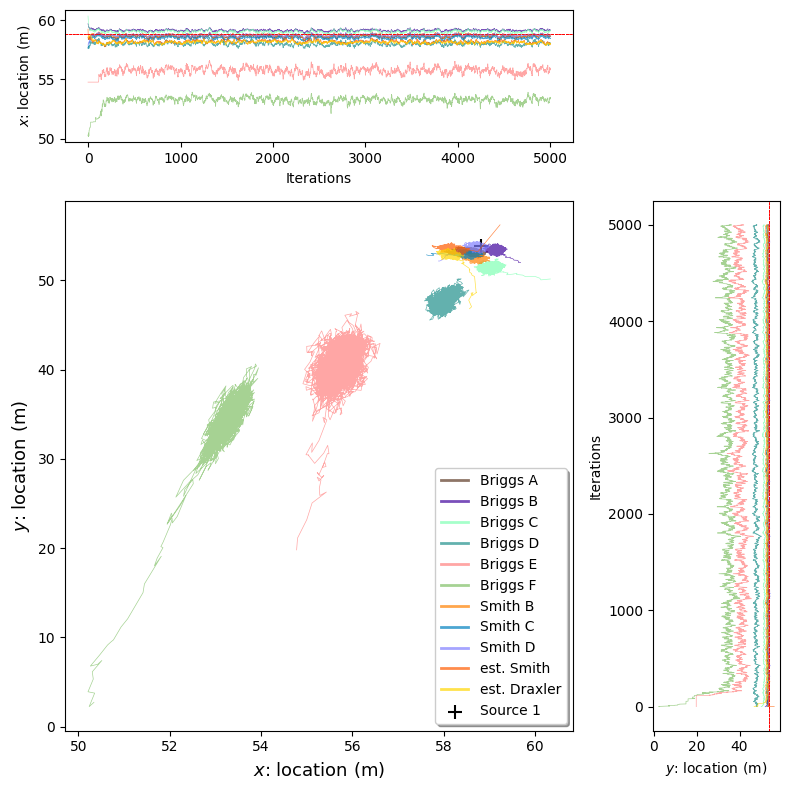

In [25]:
plot_source_location_estimates(0, source_2_mcmc_chains, source_location, False)

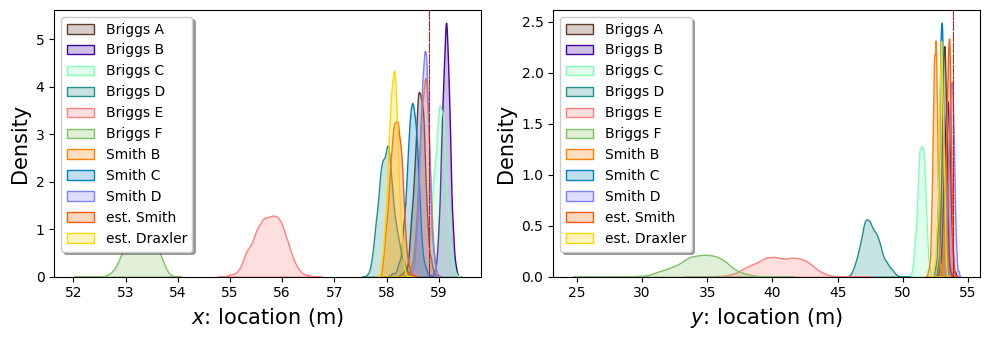

In [26]:
plot_source_location_densities(1_000, source_2_mcmc_chains, source_location, False)

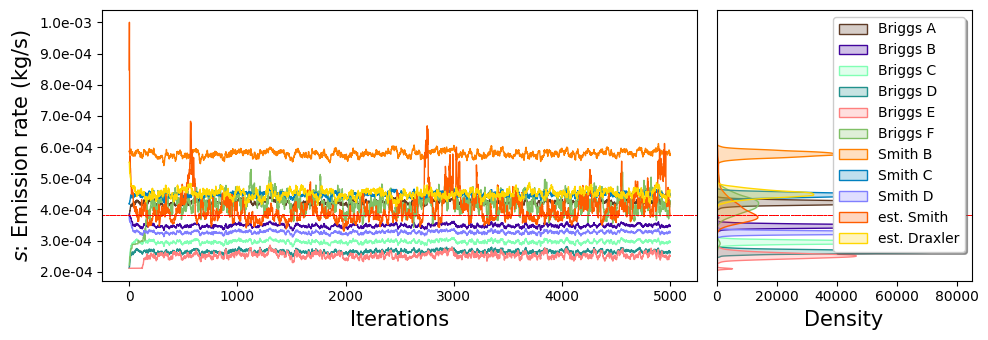

In [27]:
plot_source_emission_rate(0, source_2_mcmc_chains, atmospheric_state, False)

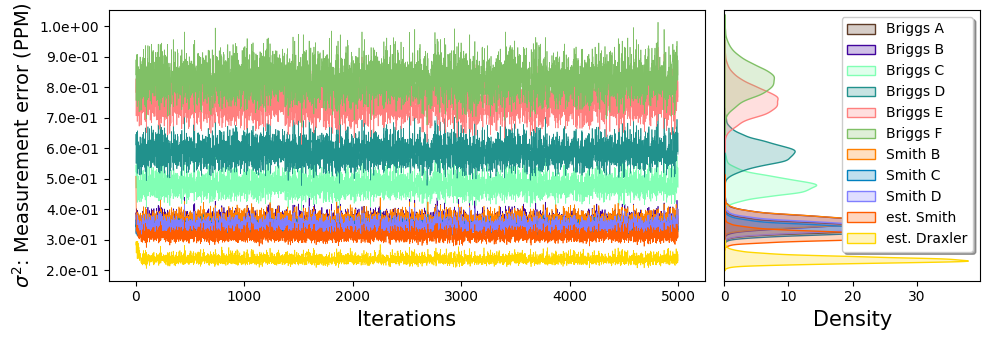

In [28]:
plot_sensor_measurement_error_variance(0, source_2_mcmc_chains, False)

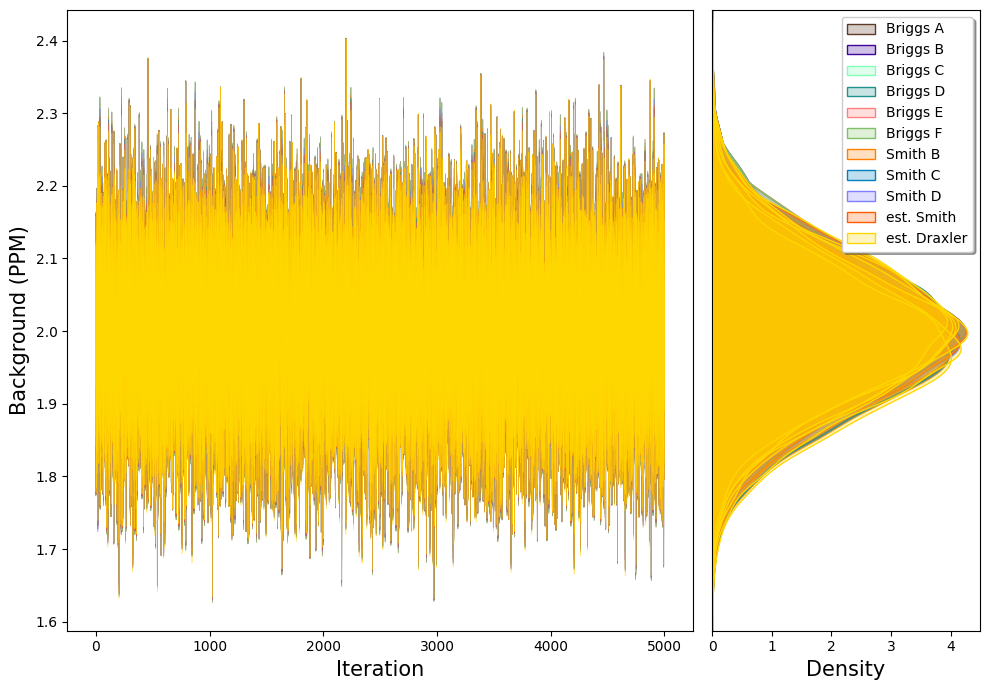

In [29]:
plot_background(0, source_2_mcmc_chains, False)

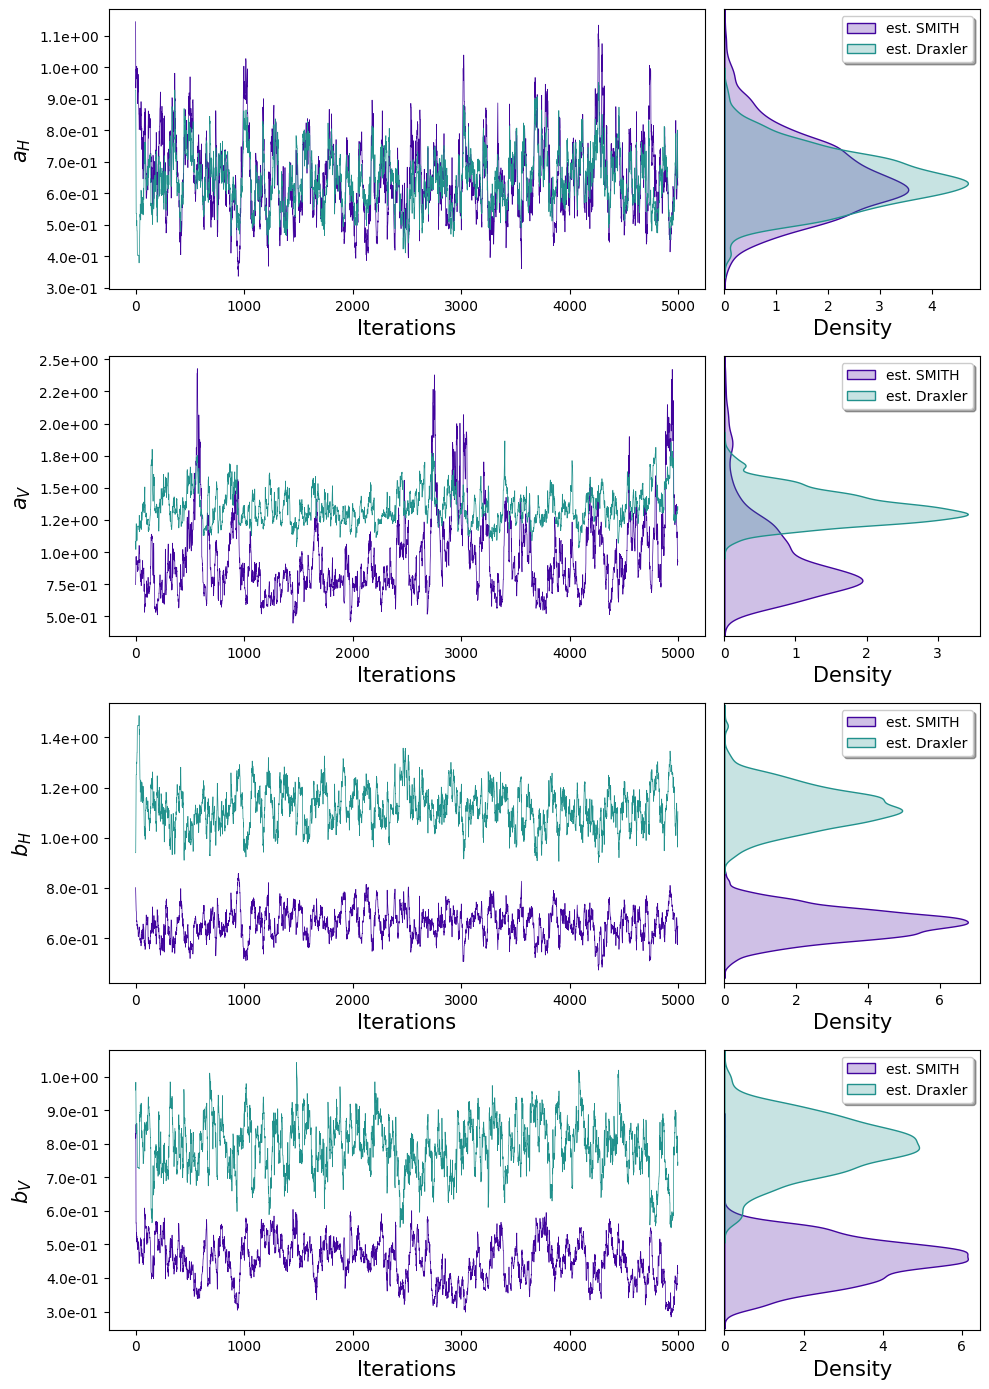

In [30]:
plot_dispersion_parameters(0, source_2_mcmc_chains_dp, False)

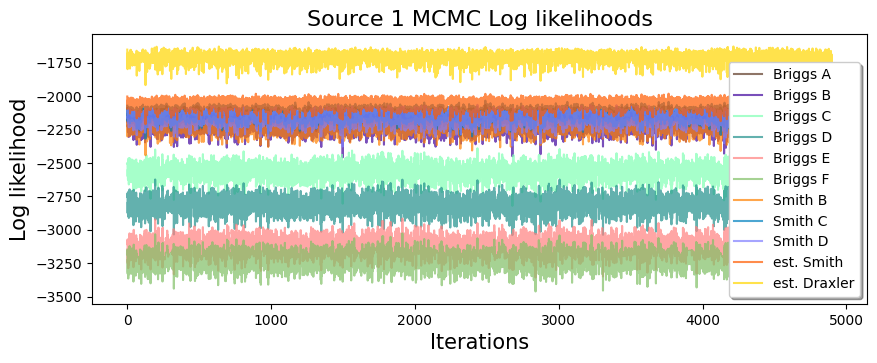

In [31]:
plot_log_likelihood(100, source_2_mcmc_chains, False)

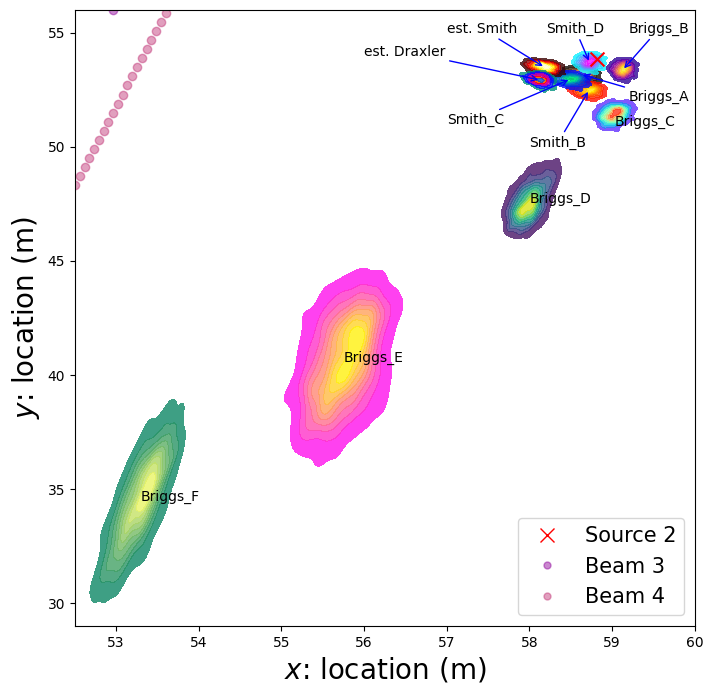

In [32]:
burn_in = 1_000
plt.figure(figsize=(8, 8))
# Briggs A
sns.kdeplot(x=Briggs_A["source_x"][burn_in:,0], y=Briggs_A["source_y"][burn_in:,0], cmap='copper', fill=True, alpha=0.8)
plt.annotate('Briggs_A', xy=(Briggs_A["source_x"][burn_in:,0].mean(), Briggs_A["source_y"][burn_in:,0].mean()), xytext=(59.2, 52), arrowprops=dict(facecolor='red', edgecolor='blue', arrowstyle='->', linewidth=1, shrinkA=1, shrinkB=1))
# Briggs B
sns.kdeplot(x=Briggs_B["source_x"][burn_in:,0], y=Briggs_B["source_y"][burn_in:,0], cmap='plasma', fill=True, alpha=0.8)
plt.annotate('Briggs_B', xy=(Briggs_B["source_x"][burn_in:,0].mean(), Briggs_B["source_y"][burn_in:,0].mean()), xytext=(59.2, 55), arrowprops=dict(facecolor='red', edgecolor='blue', arrowstyle='->', linewidth=1, shrinkA=1, shrinkB=1))
# Briggs C
sns.kdeplot(x=Briggs_C["source_x"][burn_in:,0], y=Briggs_C["source_y"][burn_in:,0], cmap='rainbow', fill=True, alpha=0.8)
plt.text(x=Briggs_C["source_x"][burn_in:,0].mean(), y=Briggs_C["source_y"][burn_in:,0].mean()-0.5, s='Briggs_C', color='black')
# Briggs D
sns.kdeplot(x=Briggs_D["source_x"][burn_in:,0], y=Briggs_D["source_y"][burn_in:,0], cmap='viridis', fill=True, alpha=0.8)
plt.text(x=Briggs_D["source_x"][burn_in:,0].mean(), y=Briggs_D["source_y"][burn_in:,0].mean(), s='Briggs_D', color='black')
# Briggs E
sns.kdeplot(x=Briggs_E["source_x"][burn_in:,0], y=Briggs_E["source_y"][burn_in:,0], cmap='spring', fill=True, alpha=0.8)
plt.text(x=Briggs_E["source_x"][burn_in:,0].mean(), y=Briggs_E["source_y"][burn_in:,0].mean(), s='Briggs_E', color='black')
# Briggs F
sns.kdeplot(x=Briggs_F["source_x"][burn_in:,0], y=Briggs_F["source_y"][burn_in:,0], cmap='summer', fill=True, alpha=0.8)
plt.text(x=Briggs_F["source_x"][burn_in:,0].mean(), y=Briggs_F["source_y"][burn_in:,0].mean(), s='Briggs_F', color='black')
# SMITH B
sns.kdeplot(x=SMITH_B["source_x"][burn_in:,0], y=SMITH_B["source_y"][burn_in:,0], cmap='autumn', fill=True, alpha=0.8)
plt.annotate('Smith_B', xy=(SMITH_B["source_x"][burn_in:,0].mean(), SMITH_B["source_y"][burn_in:,0].mean()), xytext=(58, 50), arrowprops=dict(facecolor='red', edgecolor='blue', arrowstyle='->', linewidth=1, shrinkA=1, shrinkB=1))
# SMITH C
sns.kdeplot(x=SMITH_C["source_x"][burn_in:,0], y=SMITH_C["source_y"][burn_in:,0], cmap='winter', fill=True, alpha=0.8)
plt.annotate('Smith_C', xy=(SMITH_C["source_x"][burn_in:,0].mean(), SMITH_C["source_y"][burn_in:,0].mean()), xytext=(57, 51), arrowprops=dict(facecolor='red', edgecolor='blue', arrowstyle='->', linewidth=1, shrinkA=1, shrinkB=1))
# SMITH D
sns.kdeplot(x=SMITH_D["source_x"][burn_in:,0], y=SMITH_D["source_y"][burn_in:,0], cmap='cool', fill=True, alpha=0.8)
plt.annotate('Smith_D', xy=(SMITH_D["source_x"][burn_in:,0].mean(), SMITH_D["source_y"][burn_in:,0].mean()), xytext=(58.2, 55), arrowprops=dict(facecolor='red', edgecolor='blue', arrowstyle='->', linewidth=1, shrinkA=1, shrinkB=1))
# Estimated SMITH
sns.kdeplot(x=est_SMITH["source_x"][burn_in:,0], y=est_SMITH["source_y"][burn_in:,0], cmap='hot', fill=True, alpha=0.8)
plt.annotate('est. Smith', xy=(est_SMITH["source_x"][burn_in:,0].mean(), est_SMITH["source_y"][burn_in:,0].mean()), xytext=(57, 55), arrowprops=dict(facecolor='red', edgecolor='blue', arrowstyle='->', linewidth=1, shrinkA=1, shrinkB=1))
# Estimated Draxler
sns.kdeplot(x=est_Draxler["source_x"][burn_in:,0], y=est_Draxler["source_y"][burn_in:,0], cmap='prism', fill=True, alpha=0.8)
plt.annotate('est. Draxler', xy=(est_Draxler["source_x"][burn_in:,0].mean(), est_Draxler["source_y"][burn_in:,0].mean()), xytext=(56, 54), arrowprops=dict(facecolor='red', edgecolor='blue', arrowstyle='->', linewidth=1, shrinkA=1, shrinkB=1))

# Sources
plt.scatter(sources["source_1_location"][0], sources["source_1_location"][1], color='black', marker='+', label='Source 1', alpha=0.2, s=80)
plt.scatter(sources["source_2_location"][0], sources["source_2_location"][1], color='red', marker='x', label='Source 2', s=100)
plt.scatter(sources["source_3_location"][0], sources["source_3_location"][1], color='black', marker='o', label='Source 3', alpha=0.2, s=80)
plt.scatter(sources["source_4_location"][0], sources["source_4_location"][1], color='black', marker='*', label='Source 4', alpha=0.2, s=80)
plt.scatter(60, 100, color='lightcoral', marker='.')
colors = cm.plasma(np.linspace(0, 0.95, 7))

# Extract x, y, z coordinates
x_coords_1 = [location[0] for location in point_sensors_1_location]
y_coords_1 = [location[1] for location in point_sensors_1_location]

x_coords_2 = [location[0] for location in point_sensors_2_location]
y_coords_2 = [location[1] for location in point_sensors_2_location]

x_coords_3 = [location[0] for location in point_sensors_3_location]
y_coords_3 = [location[1] for location in point_sensors_3_location]

x_coords_4 = [location[0] for location in point_sensors_4_location]
y_coords_4 = [location[1] for location in point_sensors_4_location]

x_coords_5 = [location[0] for location in point_sensors_5_location]
y_coords_5 = [location[1] for location in point_sensors_5_location]

x_coords_6 = [location[0] for location in point_sensors_6_location]
y_coords_6 = [location[1] for location in point_sensors_6_location]

x_coords_7 = [location[0] for location in point_sensors_7_location]
y_coords_7 = [location[1] for location in point_sensors_7_location]


# Plot the sensor locations
plt.scatter(x_coords_1, y_coords_1, alpha=0.5, color=colors[0])
plt.scatter(x_coords_2, y_coords_2, alpha=0.5, color=colors[1])
plt.scatter(x_coords_3, y_coords_3, alpha=0.5, color=colors[2])
plt.scatter(x_coords_4, y_coords_4, alpha=0.5, color=colors[3])
plt.scatter(x_coords_5, y_coords_5, alpha=0.5, color=colors[4])
plt.scatter(x_coords_6, y_coords_6, alpha=0.5, color=colors[5])
plt.scatter(x_coords_7, y_coords_7, alpha=0.5, color=colors[6])
plt.xlabel("$x$: location (m)", fontsize=20)
plt.ylabel("$y$: location (m)", fontsize=20)
plt.xlim(52.5, 60)
plt.ylim(29, 56)
plt.legend()
legend_elements = [ plt.Line2D([0], [0], marker='x', color='red', label='Source 2', markersize=10, linestyle='None'),
                    plt.Line2D([0], [0], marker='.', color=colors[2], label='Beam 3', markersize=10, linestyle='None', alpha=0.5),
                    plt.Line2D([0], [0], marker='.', color=colors[3], label='Beam 4', markersize=10, linestyle='None', alpha=0.5),]

plt.legend(handles=legend_elements, loc='lower right', fontsize=15)
# plt.savefig('2d_density_sensor_and_source2_location.png', dpi=300, bbox_inches='tight')
plt.show()

### 3.3 Computing model BIC

In [33]:
num_observations = observations_src2.shape[0]

burn_in = 1_000

bic_estimated = calculate_bic(burn_in, est_Draxler, 15, num_observations)
bic_smith_B = calculate_bic(burn_in, SMITH_B, 11, num_observations)
bic_smith_C = calculate_bic(burn_in, SMITH_C, 11, num_observations)
bic_smith_D = calculate_bic(burn_in, SMITH_D, 11, num_observations)
bic_briggs_A = calculate_bic(burn_in, Briggs_A, 11, num_observations)
bic_briggs_B = calculate_bic(burn_in, Briggs_B, 11, num_observations)
bic_briggs_C = calculate_bic(burn_in, Briggs_C, 11, num_observations)
bic_briggs_D = calculate_bic(burn_in, Briggs_D, 11, num_observations)
bic_briggs_E = calculate_bic(burn_in, Briggs_E, 11, num_observations)
bic_briggs_F = calculate_bic(burn_in, Briggs_F, 11, num_observations)
bic_est_SMITH = calculate_bic(burn_in, est_SMITH, 15, num_observations)

print(f'BIC of the different wind sigma parametrization schemes')
print(f'-------------------------------------------------------')
print(f"BIC estimated: {bic_estimated}")
print(f"BIC SMITH B: {bic_smith_B}")
print(f"BIC SMITH C: {bic_smith_C}")
print(f"BIC SMITH D: {bic_smith_D}")
print(f"BIC Briggs A: {bic_briggs_A}")
print(f"BIC Briggs B: {bic_briggs_B}")
print(f"BIC Briggs C: {bic_briggs_C}")
print(f"BIC Briggs D: {bic_briggs_D}")
print(f"BIC Briggs E: {bic_briggs_E}")
print(f"BIC Briggs F: {bic_briggs_F}")
print(f"BIC est_SMITH: {bic_est_SMITH}")
print(f'-------------------------------------------------------')


BIC of the different wind sigma parametrization schemes
-------------------------------------------------------
BIC estimated: 3538.8598475570093
BIC SMITH B: 4540.564851477268
BIC SMITH C: 4343.240118631416
BIC SMITH D: 4411.823177392439
BIC Briggs A: 4386.4599644215305
BIC Briggs B: 4536.813326828979
BIC Briggs C: 5212.375815574307
BIC Briggs D: 5707.216993568074
BIC Briggs E: 6323.238621895865
BIC Briggs F: 6542.704830073733
BIC est_SMITH: 4222.686491453391
-------------------------------------------------------


### 3.4 Data vs Model predictions: RMSE of Temporal Prediction
Here we compare the time series dataset collected by the different beams to the models' predictions.

In [34]:
burn_in = 1_000


# Briggs_A
MAP_Briggs_A ={
    "source_x": jnp.mean(Briggs_A["source_x"][burn_in:]),
    "source_y": jnp.mean(Briggs_A["source_y"][burn_in:]),
    "s": jnp.mean(Briggs_A["s"][burn_in:]),
    "sigma_squared": jnp.mean(Briggs_A["sigma_squared"][burn_in:]),
    "background": jnp.mean(Briggs_A["background"][burn_in:], axis=0),
}
x, y = MAP_Briggs_A["source_x"], MAP_Briggs_A["source_y"]
coupling_matrix_ref1 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref1_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="A")
coupling_matrix_ref2 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref2_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="A")
coupling_matrix_ref3 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref3_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="A")
coupling_matrix_ref4 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref4_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="A")
coupling_matrix_ref5 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref5_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="A")
coupling_matrix_ref6 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref6_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="A")
coupling_matrix_ref7 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref7_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="A")
reshaped_coupling_matrix_ref1 = coupling_matrix_ref1.reshape(wind_field_src2.shape[0],18*5, order='F')
reshaped_coupling_matrix_ref2 = coupling_matrix_ref2.reshape(wind_field_src2.shape[0],33*5, order='F')
reshaped_coupling_matrix_ref3 = coupling_matrix_ref3.reshape(wind_field_src2.shape[0],22*5, order='F')
reshaped_coupling_matrix_ref4 = coupling_matrix_ref4.reshape(wind_field_src2.shape[0],49*5, order='F')
reshaped_coupling_matrix_ref5 = coupling_matrix_ref5.reshape(wind_field_src2.shape[0],42*5, order='F')
reshaped_coupling_matrix_ref6 = coupling_matrix_ref6.reshape(wind_field_src2.shape[0],29*5, order='F')
reshaped_coupling_matrix_ref7 = coupling_matrix_ref7.reshape(wind_field_src2.shape[0],17*5, order='F')
path_averaged_coupling_matrix_ref1 = reshaped_coupling_matrix_ref1.mean(axis=1)
path_averaged_coupling_matrix_ref2 = reshaped_coupling_matrix_ref2.mean(axis=1)
path_averaged_coupling_matrix_ref3 = reshaped_coupling_matrix_ref3.mean(axis=1)
path_averaged_coupling_matrix_ref4 = reshaped_coupling_matrix_ref4.mean(axis=1)
path_averaged_coupling_matrix_ref5 = reshaped_coupling_matrix_ref5.mean(axis=1)
path_averaged_coupling_matrix_ref6 = reshaped_coupling_matrix_ref6.mean(axis=1)
path_averaged_coupling_matrix_ref7 = reshaped_coupling_matrix_ref7.mean(axis=1)
path_averaged_A = [path_averaged_coupling_matrix_ref1, path_averaged_coupling_matrix_ref2, path_averaged_coupling_matrix_ref3, path_averaged_coupling_matrix_ref4, path_averaged_coupling_matrix_ref5, path_averaged_coupling_matrix_ref6, path_averaged_coupling_matrix_ref7]
A_Briggs_A = jnp.array(path_averaged_A).reshape(-1,1)


# Briggs_B
MAP_Briggs_B ={
    "source_x": jnp.mean(Briggs_B["source_x"][burn_in:]),
    "source_y": jnp.mean(Briggs_B["source_y"][burn_in:]),
    "s": jnp.mean(Briggs_B["s"][burn_in:]),
    "sigma_squared": jnp.mean(Briggs_B["sigma_squared"][burn_in:]),
    "background": jnp.mean(Briggs_B["background"][burn_in:], axis=0),
}
x, y = MAP_Briggs_B["source_x"], MAP_Briggs_B["source_y"]
coupling_matrix_ref1 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref1_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="B")
coupling_matrix_ref2 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref2_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="B")
coupling_matrix_ref3 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref3_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="B")
coupling_matrix_ref4 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref4_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="B")
coupling_matrix_ref5 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref5_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="B")
coupling_matrix_ref6 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref6_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="B")
coupling_matrix_ref7 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref7_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="B")
reshaped_coupling_matrix_ref1 = coupling_matrix_ref1.reshape(wind_field_src2.shape[0],18*5, order='F')
reshaped_coupling_matrix_ref2 = coupling_matrix_ref2.reshape(wind_field_src2.shape[0],33*5, order='F')
reshaped_coupling_matrix_ref3 = coupling_matrix_ref3.reshape(wind_field_src2.shape[0],22*5, order='F')
reshaped_coupling_matrix_ref4 = coupling_matrix_ref4.reshape(wind_field_src2.shape[0],49*5, order='F')
reshaped_coupling_matrix_ref5 = coupling_matrix_ref5.reshape(wind_field_src2.shape[0],42*5, order='F')
reshaped_coupling_matrix_ref6 = coupling_matrix_ref6.reshape(wind_field_src2.shape[0],29*5, order='F')
reshaped_coupling_matrix_ref7 = coupling_matrix_ref7.reshape(wind_field_src2.shape[0],17*5, order='F')
path_averaged_coupling_matrix_ref1 = reshaped_coupling_matrix_ref1.mean(axis=1)
path_averaged_coupling_matrix_ref2 = reshaped_coupling_matrix_ref2.mean(axis=1)
path_averaged_coupling_matrix_ref3 = reshaped_coupling_matrix_ref3.mean(axis=1)
path_averaged_coupling_matrix_ref4 = reshaped_coupling_matrix_ref4.mean(axis=1)
path_averaged_coupling_matrix_ref5 = reshaped_coupling_matrix_ref5.mean(axis=1)
path_averaged_coupling_matrix_ref6 = reshaped_coupling_matrix_ref6.mean(axis=1)
path_averaged_coupling_matrix_ref7 = reshaped_coupling_matrix_ref7.mean(axis=1)
path_averaged_A = [path_averaged_coupling_matrix_ref1, path_averaged_coupling_matrix_ref2, path_averaged_coupling_matrix_ref3, path_averaged_coupling_matrix_ref4, path_averaged_coupling_matrix_ref5, path_averaged_coupling_matrix_ref6, path_averaged_coupling_matrix_ref7]
A_Briggs_B = jnp.array(path_averaged_A).reshape(-1,1)


# Briggs_C
MAP_Briggs_C ={
    "source_x": jnp.mean(Briggs_C["source_x"][burn_in:]),
    "source_y": jnp.mean(Briggs_C["source_y"][burn_in:]),
    "s": jnp.mean(Briggs_C["s"][burn_in:]),
    "sigma_squared": jnp.mean(Briggs_C["sigma_squared"][burn_in:]),
    "background": jnp.mean(Briggs_C["background"][burn_in:], axis=0),
}
x, y = MAP_Briggs_C["source_x"], MAP_Briggs_C["source_y"]
coupling_matrix_ref1 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref1_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="C")
coupling_matrix_ref2 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref2_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="C")
coupling_matrix_ref3 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref3_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="C")
coupling_matrix_ref4 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref4_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="C")
coupling_matrix_ref5 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref5_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="C")
coupling_matrix_ref6 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref6_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="C")
coupling_matrix_ref7 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref7_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="C")
reshaped_coupling_matrix_ref1 = coupling_matrix_ref1.reshape(wind_field_src2.shape[0],18*5, order='F')
reshaped_coupling_matrix_ref2 = coupling_matrix_ref2.reshape(wind_field_src2.shape[0],33*5, order='F')
reshaped_coupling_matrix_ref3 = coupling_matrix_ref3.reshape(wind_field_src2.shape[0],22*5, order='F')
reshaped_coupling_matrix_ref4 = coupling_matrix_ref4.reshape(wind_field_src2.shape[0],49*5, order='F')
reshaped_coupling_matrix_ref5 = coupling_matrix_ref5.reshape(wind_field_src2.shape[0],42*5, order='F')
reshaped_coupling_matrix_ref6 = coupling_matrix_ref6.reshape(wind_field_src2.shape[0],29*5, order='F')
reshaped_coupling_matrix_ref7 = coupling_matrix_ref7.reshape(wind_field_src2.shape[0],17*5, order='F')
path_averaged_coupling_matrix_ref1 = reshaped_coupling_matrix_ref1.mean(axis=1)
path_averaged_coupling_matrix_ref2 = reshaped_coupling_matrix_ref2.mean(axis=1)
path_averaged_coupling_matrix_ref3 = reshaped_coupling_matrix_ref3.mean(axis=1)
path_averaged_coupling_matrix_ref4 = reshaped_coupling_matrix_ref4.mean(axis=1)
path_averaged_coupling_matrix_ref5 = reshaped_coupling_matrix_ref5.mean(axis=1)
path_averaged_coupling_matrix_ref6 = reshaped_coupling_matrix_ref6.mean(axis=1)
path_averaged_coupling_matrix_ref7 = reshaped_coupling_matrix_ref7.mean(axis=1)
path_averaged_A = [path_averaged_coupling_matrix_ref1, path_averaged_coupling_matrix_ref2, path_averaged_coupling_matrix_ref3, path_averaged_coupling_matrix_ref4, path_averaged_coupling_matrix_ref5, path_averaged_coupling_matrix_ref6, path_averaged_coupling_matrix_ref7]
A_Briggs_C = jnp.array(path_averaged_A).reshape(-1,1)


# Briggs D
MAP_Briggs_D ={
    "source_x": jnp.mean(Briggs_D["source_x"][burn_in:]),
    "source_y": jnp.mean(Briggs_D["source_y"][burn_in:]),
    "s": jnp.mean(Briggs_D["s"][burn_in:]),
    "sigma_squared": jnp.mean(Briggs_D["sigma_squared"][burn_in:]),
    "background": jnp.mean(Briggs_D["background"][burn_in:], axis=0),
}
x, y = MAP_Briggs_D["source_x"], MAP_Briggs_D["source_y"]
coupling_matrix_ref1 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref1_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="D")
coupling_matrix_ref2 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref2_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="D")
coupling_matrix_ref3 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref3_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="D")
coupling_matrix_ref4 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref4_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="D")
coupling_matrix_ref5 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref5_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="D")
coupling_matrix_ref6 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref6_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="D")
coupling_matrix_ref7 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref7_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="D")
reshaped_coupling_matrix_ref1 = coupling_matrix_ref1.reshape(wind_field_src2.shape[0],18*5, order='F')
reshaped_coupling_matrix_ref2 = coupling_matrix_ref2.reshape(wind_field_src2.shape[0],33*5, order='F')
reshaped_coupling_matrix_ref3 = coupling_matrix_ref3.reshape(wind_field_src2.shape[0],22*5, order='F')
reshaped_coupling_matrix_ref4 = coupling_matrix_ref4.reshape(wind_field_src2.shape[0],49*5, order='F')
reshaped_coupling_matrix_ref5 = coupling_matrix_ref5.reshape(wind_field_src2.shape[0],42*5, order='F')
reshaped_coupling_matrix_ref6 = coupling_matrix_ref6.reshape(wind_field_src2.shape[0],29*5, order='F')
reshaped_coupling_matrix_ref7 = coupling_matrix_ref7.reshape(wind_field_src2.shape[0],17*5, order='F')
path_averaged_coupling_matrix_ref1 = reshaped_coupling_matrix_ref1.mean(axis=1)
path_averaged_coupling_matrix_ref2 = reshaped_coupling_matrix_ref2.mean(axis=1)
path_averaged_coupling_matrix_ref3 = reshaped_coupling_matrix_ref3.mean(axis=1)
path_averaged_coupling_matrix_ref4 = reshaped_coupling_matrix_ref4.mean(axis=1)
path_averaged_coupling_matrix_ref5 = reshaped_coupling_matrix_ref5.mean(axis=1)
path_averaged_coupling_matrix_ref6 = reshaped_coupling_matrix_ref6.mean(axis=1)
path_averaged_coupling_matrix_ref7 = reshaped_coupling_matrix_ref7.mean(axis=1)
path_averaged_A = [path_averaged_coupling_matrix_ref1, path_averaged_coupling_matrix_ref2, path_averaged_coupling_matrix_ref3, path_averaged_coupling_matrix_ref4, path_averaged_coupling_matrix_ref5, path_averaged_coupling_matrix_ref6, path_averaged_coupling_matrix_ref7]
A_Briggs_D = jnp.array(path_averaged_A).reshape(-1,1)


# Briggs E
MAP_Briggs_E ={
    "source_x": jnp.mean(Briggs_E["source_x"][burn_in:]),
    "source_y": jnp.mean(Briggs_E["source_y"][burn_in:]),
    "s": jnp.mean(Briggs_E["s"][burn_in:]),
    "sigma_squared": jnp.mean(Briggs_E["sigma_squared"][burn_in:]),
    "background": jnp.mean(Briggs_E["background"][burn_in:], axis=0),
}
x, y = MAP_Briggs_E["source_x"], MAP_Briggs_E["source_y"]
coupling_matrix_ref1 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref1_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="E")
coupling_matrix_ref2 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref2_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="E")
coupling_matrix_ref3 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref3_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="E")
coupling_matrix_ref4 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref4_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="E")
coupling_matrix_ref5 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref5_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="E")
coupling_matrix_ref6 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref6_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="E")
coupling_matrix_ref7 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref7_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="E")
reshaped_coupling_matrix_ref1 = coupling_matrix_ref1.reshape(wind_field_src2.shape[0],18*5, order='F')
reshaped_coupling_matrix_ref2 = coupling_matrix_ref2.reshape(wind_field_src2.shape[0],33*5, order='F')
reshaped_coupling_matrix_ref3 = coupling_matrix_ref3.reshape(wind_field_src2.shape[0],22*5, order='F')
reshaped_coupling_matrix_ref4 = coupling_matrix_ref4.reshape(wind_field_src2.shape[0],49*5, order='F')
reshaped_coupling_matrix_ref5 = coupling_matrix_ref5.reshape(wind_field_src2.shape[0],42*5, order='F')
reshaped_coupling_matrix_ref6 = coupling_matrix_ref6.reshape(wind_field_src2.shape[0],29*5, order='F')
reshaped_coupling_matrix_ref7 = coupling_matrix_ref7.reshape(wind_field_src2.shape[0],17*5, order='F')
path_averaged_coupling_matrix_ref1 = reshaped_coupling_matrix_ref1.mean(axis=1)
path_averaged_coupling_matrix_ref2 = reshaped_coupling_matrix_ref2.mean(axis=1)
path_averaged_coupling_matrix_ref3 = reshaped_coupling_matrix_ref3.mean(axis=1)
path_averaged_coupling_matrix_ref4 = reshaped_coupling_matrix_ref4.mean(axis=1)
path_averaged_coupling_matrix_ref5 = reshaped_coupling_matrix_ref5.mean(axis=1)
path_averaged_coupling_matrix_ref6 = reshaped_coupling_matrix_ref6.mean(axis=1)
path_averaged_coupling_matrix_ref7 = reshaped_coupling_matrix_ref7.mean(axis=1)
path_averaged_A = [path_averaged_coupling_matrix_ref1, path_averaged_coupling_matrix_ref2, path_averaged_coupling_matrix_ref3, path_averaged_coupling_matrix_ref4, path_averaged_coupling_matrix_ref5, path_averaged_coupling_matrix_ref6, path_averaged_coupling_matrix_ref7]
A_Briggs_E = jnp.array(path_averaged_A).reshape(-1,1)


# Briggs F
MAP_Briggs_F ={
    "source_x": jnp.mean(Briggs_F["source_x"][burn_in:]),
    "source_y": jnp.mean(Briggs_F["source_y"][burn_in:]),
    "s": jnp.mean(Briggs_F["s"][burn_in:]),
    "sigma_squared": jnp.mean(Briggs_F["sigma_squared"][burn_in:]),
    "background": jnp.mean(Briggs_F["background"][burn_in:], axis=0),
}
x, y = MAP_Briggs_F["source_x"], MAP_Briggs_F["source_y"]
coupling_matrix_ref1 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref1_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="F")
coupling_matrix_ref2 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref2_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="F")
coupling_matrix_ref3 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref3_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="F")
coupling_matrix_ref4 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref4_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="F")
coupling_matrix_ref5 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref5_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="F")
coupling_matrix_ref6 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref6_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="F")
coupling_matrix_ref7 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref7_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="Briggs", stability_class="F")
reshaped_coupling_matrix_ref1 = coupling_matrix_ref1.reshape(wind_field_src2.shape[0],18*5, order='F')
reshaped_coupling_matrix_ref2 = coupling_matrix_ref2.reshape(wind_field_src2.shape[0],33*5, order='F')
reshaped_coupling_matrix_ref3 = coupling_matrix_ref3.reshape(wind_field_src2.shape[0],22*5, order='F')
reshaped_coupling_matrix_ref4 = coupling_matrix_ref4.reshape(wind_field_src2.shape[0],49*5, order='F')
reshaped_coupling_matrix_ref5 = coupling_matrix_ref5.reshape(wind_field_src2.shape[0],42*5, order='F')
reshaped_coupling_matrix_ref6 = coupling_matrix_ref6.reshape(wind_field_src2.shape[0],29*5, order='F')
reshaped_coupling_matrix_ref7 = coupling_matrix_ref7.reshape(wind_field_src2.shape[0],17*5, order='F')
path_averaged_coupling_matrix_ref1 = reshaped_coupling_matrix_ref1.mean(axis=1)
path_averaged_coupling_matrix_ref2 = reshaped_coupling_matrix_ref2.mean(axis=1)
path_averaged_coupling_matrix_ref3 = reshaped_coupling_matrix_ref3.mean(axis=1)
path_averaged_coupling_matrix_ref4 = reshaped_coupling_matrix_ref4.mean(axis=1)
path_averaged_coupling_matrix_ref5 = reshaped_coupling_matrix_ref5.mean(axis=1)
path_averaged_coupling_matrix_ref6 = reshaped_coupling_matrix_ref6.mean(axis=1)
path_averaged_coupling_matrix_ref7 = reshaped_coupling_matrix_ref7.mean(axis=1)
path_averaged_A = [path_averaged_coupling_matrix_ref1, path_averaged_coupling_matrix_ref2, path_averaged_coupling_matrix_ref3, path_averaged_coupling_matrix_ref4, path_averaged_coupling_matrix_ref5, path_averaged_coupling_matrix_ref6, path_averaged_coupling_matrix_ref7]
A_Briggs_F = jnp.array(path_averaged_A).reshape(-1,1)


# Smith B
MAP_SMITH_B ={
    "source_x": jnp.mean(SMITH_B["source_x"][burn_in:]),
    "source_y": jnp.mean(SMITH_B["source_y"][burn_in:]),
    "s": jnp.mean(SMITH_B["s"][burn_in:]),
    "sigma_squared": jnp.mean(SMITH_B["sigma_squared"][burn_in:]),
    "background": jnp.mean(SMITH_B["background"][burn_in:], axis=0),
}
x, y = MAP_SMITH_B["source_x"], MAP_SMITH_B["source_y"]
coupling_matrix_ref1 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref1_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="SMITH")
coupling_matrix_ref2 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref2_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="SMITH")
coupling_matrix_ref3 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref3_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="SMITH")
coupling_matrix_ref4 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref4_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="SMITH")    
coupling_matrix_ref5 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref5_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="SMITH")
coupling_matrix_ref6 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref6_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="SMITH")
coupling_matrix_ref7 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref7_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="SMITH")
reshaped_coupling_matrix_ref1 = coupling_matrix_ref1.reshape(wind_field_src2.shape[0],18*5, order='F')
reshaped_coupling_matrix_ref2 = coupling_matrix_ref2.reshape(wind_field_src2.shape[0],33*5, order='F')
reshaped_coupling_matrix_ref3 = coupling_matrix_ref3.reshape(wind_field_src2.shape[0],22*5, order='F')
reshaped_coupling_matrix_ref4 = coupling_matrix_ref4.reshape(wind_field_src2.shape[0],49*5, order='F')
reshaped_coupling_matrix_ref5 = coupling_matrix_ref5.reshape(wind_field_src2.shape[0],42*5, order='F')
reshaped_coupling_matrix_ref6 = coupling_matrix_ref6.reshape(wind_field_src2.shape[0],29*5, order='F')
reshaped_coupling_matrix_ref7 = coupling_matrix_ref7.reshape(wind_field_src2.shape[0],17*5, order='F')
path_averaged_coupling_matrix_ref1 = reshaped_coupling_matrix_ref1.mean(axis=1)
path_averaged_coupling_matrix_ref2 = reshaped_coupling_matrix_ref2.mean(axis=1)
path_averaged_coupling_matrix_ref3 = reshaped_coupling_matrix_ref3.mean(axis=1)
path_averaged_coupling_matrix_ref4 = reshaped_coupling_matrix_ref4.mean(axis=1)
path_averaged_coupling_matrix_ref5 = reshaped_coupling_matrix_ref5.mean(axis=1)
path_averaged_coupling_matrix_ref6 = reshaped_coupling_matrix_ref6.mean(axis=1)
path_averaged_coupling_matrix_ref7 = reshaped_coupling_matrix_ref7.mean(axis=1)
path_averaged_A = [path_averaged_coupling_matrix_ref1, path_averaged_coupling_matrix_ref2, path_averaged_coupling_matrix_ref3, path_averaged_coupling_matrix_ref4, path_averaged_coupling_matrix_ref5, path_averaged_coupling_matrix_ref6, path_averaged_coupling_matrix_ref7]
A_SMITH_B = jnp.array(path_averaged_A).reshape(-1,1)


# Smith C
MAP_SMITH_C ={
    "source_x": jnp.mean(SMITH_C["source_x"][burn_in:]),
    "source_y": jnp.mean(SMITH_C["source_y"][burn_in:]),
    "s": jnp.mean(SMITH_C["s"][burn_in:]),
    "sigma_squared": jnp.mean(SMITH_C["sigma_squared"][burn_in:]),
    "background": jnp.mean(SMITH_C["background"][burn_in:], axis=0),
}
x, y = MAP_SMITH_C["source_x"], MAP_SMITH_C["source_y"]
coupling_matrix_ref1 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref1_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="SMITH")
coupling_matrix_ref2 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref2_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="SMITH")
coupling_matrix_ref3 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref3_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="SMITH")
coupling_matrix_ref4 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref4_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="SMITH")    
coupling_matrix_ref5 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref5_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="SMITH")
coupling_matrix_ref6 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref6_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="SMITH")
coupling_matrix_ref7 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref7_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="SMITH")
reshaped_coupling_matrix_ref1 = coupling_matrix_ref1.reshape(wind_field_src2.shape[0],18*5, order='F')
reshaped_coupling_matrix_ref2 = coupling_matrix_ref2.reshape(wind_field_src2.shape[0],33*5, order='F')
reshaped_coupling_matrix_ref3 = coupling_matrix_ref3.reshape(wind_field_src2.shape[0],22*5, order='F')
reshaped_coupling_matrix_ref4 = coupling_matrix_ref4.reshape(wind_field_src2.shape[0],49*5, order='F')
reshaped_coupling_matrix_ref5 = coupling_matrix_ref5.reshape(wind_field_src2.shape[0],42*5, order='F')
reshaped_coupling_matrix_ref6 = coupling_matrix_ref6.reshape(wind_field_src2.shape[0],29*5, order='F')
reshaped_coupling_matrix_ref7 = coupling_matrix_ref7.reshape(wind_field_src2.shape[0],17*5, order='F')
path_averaged_coupling_matrix_ref1 = reshaped_coupling_matrix_ref1.mean(axis=1)
path_averaged_coupling_matrix_ref2 = reshaped_coupling_matrix_ref2.mean(axis=1)
path_averaged_coupling_matrix_ref3 = reshaped_coupling_matrix_ref3.mean(axis=1)
path_averaged_coupling_matrix_ref4 = reshaped_coupling_matrix_ref4.mean(axis=1)
path_averaged_coupling_matrix_ref5 = reshaped_coupling_matrix_ref5.mean(axis=1)
path_averaged_coupling_matrix_ref6 = reshaped_coupling_matrix_ref6.mean(axis=1)
path_averaged_coupling_matrix_ref7 = reshaped_coupling_matrix_ref7.mean(axis=1)
path_averaged_A = [path_averaged_coupling_matrix_ref1, path_averaged_coupling_matrix_ref2, path_averaged_coupling_matrix_ref3, path_averaged_coupling_matrix_ref4, path_averaged_coupling_matrix_ref5, path_averaged_coupling_matrix_ref6, path_averaged_coupling_matrix_ref7]
A_SMITH_C = jnp.array(path_averaged_A).reshape(-1,1)


# Smith D
MAP_SMITH_D ={
    "source_x": jnp.mean(SMITH_D["source_x"][burn_in:]),
    "source_y": jnp.mean(SMITH_D["source_y"][burn_in:]),
    "s": jnp.mean(SMITH_D["s"][burn_in:]),
    "sigma_squared": jnp.mean(SMITH_D["sigma_squared"][burn_in:]),
    "background": jnp.mean(SMITH_D["background"][burn_in:], axis=0),
}
x, y = MAP_SMITH_D["source_x"], MAP_SMITH_D["source_y"]
coupling_matrix_ref1 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref1_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="SMITH")
coupling_matrix_ref2 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref2_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="SMITH")
coupling_matrix_ref3 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref3_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="SMITH")
coupling_matrix_ref4 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref4_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="SMITH")    
coupling_matrix_ref5 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref5_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="SMITH")
coupling_matrix_ref6 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref6_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="SMITH")
coupling_matrix_ref7 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref7_src2, jnp.array([x]), jnp.array([y]), None, 1.0, 1.0, 1.0, 1.0, simulation = False, estimated=False, scheme="SMITH")
reshaped_coupling_matrix_ref1 = coupling_matrix_ref1.reshape(wind_field_src2.shape[0],18*5, order='F')
reshaped_coupling_matrix_ref2 = coupling_matrix_ref2.reshape(wind_field_src2.shape[0],33*5, order='F')
reshaped_coupling_matrix_ref3 = coupling_matrix_ref3.reshape(wind_field_src2.shape[0],22*5, order='F')
reshaped_coupling_matrix_ref4 = coupling_matrix_ref4.reshape(wind_field_src2.shape[0],49*5, order='F')
reshaped_coupling_matrix_ref5 = coupling_matrix_ref5.reshape(wind_field_src2.shape[0],42*5, order='F')
reshaped_coupling_matrix_ref6 = coupling_matrix_ref6.reshape(wind_field_src2.shape[0],29*5, order='F')
reshaped_coupling_matrix_ref7 = coupling_matrix_ref7.reshape(wind_field_src2.shape[0],17*5, order='F')
path_averaged_coupling_matrix_ref1 = reshaped_coupling_matrix_ref1.mean(axis=1)
path_averaged_coupling_matrix_ref2 = reshaped_coupling_matrix_ref2.mean(axis=1)
path_averaged_coupling_matrix_ref3 = reshaped_coupling_matrix_ref3.mean(axis=1)
path_averaged_coupling_matrix_ref4 = reshaped_coupling_matrix_ref4.mean(axis=1)
path_averaged_coupling_matrix_ref5 = reshaped_coupling_matrix_ref5.mean(axis=1)
path_averaged_coupling_matrix_ref6 = reshaped_coupling_matrix_ref6.mean(axis=1)
path_averaged_coupling_matrix_ref7 = reshaped_coupling_matrix_ref7.mean(axis=1)
path_averaged_A = [path_averaged_coupling_matrix_ref1, path_averaged_coupling_matrix_ref2, path_averaged_coupling_matrix_ref3, path_averaged_coupling_matrix_ref4, path_averaged_coupling_matrix_ref5, path_averaged_coupling_matrix_ref6, path_averaged_coupling_matrix_ref7]
A_SMITH_D = jnp.array(path_averaged_A).reshape(-1,1)


# Estimated Smith
MAP_est_SMITH ={
    "source_x": jnp.mean(est_SMITH["source_x"][burn_in:]),
    "source_y": jnp.mean(est_SMITH["source_y"][burn_in:]),
    "s": jnp.mean(est_SMITH["s"][burn_in:]),
    "sigma_squared": jnp.mean(est_SMITH["sigma_squared"][burn_in:]),
    "background": jnp.mean(est_SMITH["background"][burn_in:], axis=0),
    "a_H": jnp.mean(est_SMITH["a_H"][burn_in:]),
    "a_V": jnp.mean(est_SMITH["a_V"][burn_in:]),
    "b_H": jnp.mean(est_SMITH["b_H"][burn_in:]),
    "b_V": jnp.mean(est_SMITH["b_V"][burn_in:]),
}
x, y = MAP_est_SMITH["source_x"], MAP_est_SMITH["source_y"]
coupling_matrix_ref1 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref1_src2, jnp.array([x]), jnp.array([y]), None, jnp.array(MAP_est_SMITH["a_H"]), jnp.array(MAP_est_SMITH["a_V"]), jnp.array(MAP_est_SMITH["b_H"]), jnp.array(MAP_est_SMITH["b_V"]), simulation = False, estimated=True, scheme="SMITH")
coupling_matrix_ref2 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref2_src2, jnp.array([x]), jnp.array([y]), None, jnp.array(MAP_est_SMITH["a_H"]), jnp.array(MAP_est_SMITH["a_V"]), jnp.array(MAP_est_SMITH["b_H"]), jnp.array(MAP_est_SMITH["b_V"]), simulation = False, estimated=True, scheme="SMITH")
coupling_matrix_ref3 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref3_src2, jnp.array([x]), jnp.array([y]), None, jnp.array(MAP_est_SMITH["a_H"]), jnp.array(MAP_est_SMITH["a_V"]), jnp.array(MAP_est_SMITH["b_H"]), jnp.array(MAP_est_SMITH["b_V"]), simulation = False, estimated=True, scheme="SMITH")
coupling_matrix_ref4 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref4_src2, jnp.array([x]), jnp.array([y]), None, jnp.array(MAP_est_SMITH["a_H"]), jnp.array(MAP_est_SMITH["a_V"]), jnp.array(MAP_est_SMITH["b_H"]), jnp.array(MAP_est_SMITH["b_V"]), simulation = False, estimated=True, scheme="SMITH")    
coupling_matrix_ref5 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref5_src2, jnp.array([x]), jnp.array([y]), None, jnp.array(MAP_est_SMITH["a_H"]), jnp.array(MAP_est_SMITH["a_V"]), jnp.array(MAP_est_SMITH["b_H"]), jnp.array(MAP_est_SMITH["b_V"]), simulation = False, estimated=True, scheme="SMITH")
coupling_matrix_ref6 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref6_src2, jnp.array([x]), jnp.array([y]), None, jnp.array(MAP_est_SMITH["a_H"]), jnp.array(MAP_est_SMITH["a_V"]), jnp.array(MAP_est_SMITH["b_H"]), jnp.array(MAP_est_SMITH["b_V"]), simulation = False, estimated=True, scheme="SMITH")
coupling_matrix_ref7 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref7_src2, jnp.array([x]), jnp.array([y]), None, jnp.array(MAP_est_SMITH["a_H"]), jnp.array(MAP_est_SMITH["a_V"]), jnp.array(MAP_est_SMITH["b_H"]), jnp.array(MAP_est_SMITH["b_V"]), simulation = False, estimated=True, scheme="SMITH")
reshaped_coupling_matrix_ref1 = coupling_matrix_ref1.reshape(wind_field_src2.shape[0],18*5, order='F')
reshaped_coupling_matrix_ref2 = coupling_matrix_ref2.reshape(wind_field_src2.shape[0],33*5, order='F')
reshaped_coupling_matrix_ref3 = coupling_matrix_ref3.reshape(wind_field_src2.shape[0],22*5, order='F')
reshaped_coupling_matrix_ref4 = coupling_matrix_ref4.reshape(wind_field_src2.shape[0],49*5, order='F')
reshaped_coupling_matrix_ref5 = coupling_matrix_ref5.reshape(wind_field_src2.shape[0],42*5, order='F')
reshaped_coupling_matrix_ref6 = coupling_matrix_ref6.reshape(wind_field_src2.shape[0],29*5, order='F')
reshaped_coupling_matrix_ref7 = coupling_matrix_ref7.reshape(wind_field_src2.shape[0],17*5, order='F')
path_averaged_coupling_matrix_ref1 = reshaped_coupling_matrix_ref1.mean(axis=1)
path_averaged_coupling_matrix_ref2 = reshaped_coupling_matrix_ref2.mean(axis=1)
path_averaged_coupling_matrix_ref3 = reshaped_coupling_matrix_ref3.mean(axis=1)
path_averaged_coupling_matrix_ref4 = reshaped_coupling_matrix_ref4.mean(axis=1)
path_averaged_coupling_matrix_ref5 = reshaped_coupling_matrix_ref5.mean(axis=1)
path_averaged_coupling_matrix_ref6 = reshaped_coupling_matrix_ref6.mean(axis=1)
path_averaged_coupling_matrix_ref7 = reshaped_coupling_matrix_ref7.mean(axis=1)
path_averaged_A = [path_averaged_coupling_matrix_ref1, path_averaged_coupling_matrix_ref2, path_averaged_coupling_matrix_ref3, path_averaged_coupling_matrix_ref4, path_averaged_coupling_matrix_ref5, path_averaged_coupling_matrix_ref6, path_averaged_coupling_matrix_ref7]
A_est_SMITH = jnp.array(path_averaged_A).reshape(-1,1)


# Estimated Draxler
MAP_est_Draxler ={
    "source_x": jnp.mean(est_Draxler["source_x"][burn_in:]),
    "source_y": jnp.mean(est_Draxler["source_y"][burn_in:]),
    "s": jnp.mean(est_Draxler["s"][burn_in:]),
    "sigma_squared": jnp.mean(est_Draxler["sigma_squared"][burn_in:]),
    "background": jnp.mean(est_Draxler["background"][burn_in:], axis=0),
    "a_H": jnp.mean(est_Draxler["a_H"][burn_in:]),
    "a_V": jnp.mean(est_Draxler["a_V"][burn_in:]),
    "b_H": jnp.mean(est_Draxler["b_H"][burn_in:]),
    "b_V": jnp.mean(est_Draxler["b_V"][burn_in:]),
}
x, y = MAP_est_Draxler["source_x"], MAP_est_Draxler["source_y"]
coupling_matrix_ref1 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref1_src2, jnp.array([x]), jnp.array([y]), None, jnp.array(MAP_est_Draxler["a_H"]), jnp.array(MAP_est_Draxler["a_V"]), jnp.array(MAP_est_Draxler["b_H"]), jnp.array(MAP_est_Draxler["b_V"]), simulation = False, estimated=True, scheme="Draxler")
coupling_matrix_ref2 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref2_src2, jnp.array([x]), jnp.array([y]), None, jnp.array(MAP_est_Draxler["a_H"]), jnp.array(MAP_est_Draxler["a_V"]), jnp.array(MAP_est_Draxler["b_H"]), jnp.array(MAP_est_Draxler["b_V"]), simulation = False, estimated=True, scheme="Draxler")
coupling_matrix_ref3 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref3_src2, jnp.array([x]), jnp.array([y]), None, jnp.array(MAP_est_Draxler["a_H"]), jnp.array(MAP_est_Draxler["a_V"]), jnp.array(MAP_est_Draxler["b_H"]), jnp.array(MAP_est_Draxler["b_V"]), simulation = False, estimated=True, scheme="Draxler")
coupling_matrix_ref4 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref4_src2, jnp.array([x]), jnp.array([y]), None, jnp.array(MAP_est_Draxler["a_H"]), jnp.array(MAP_est_Draxler["a_V"]), jnp.array(MAP_est_Draxler["b_H"]), jnp.array(MAP_est_Draxler["b_V"]), simulation = False, estimated=True, scheme="Draxler")    
coupling_matrix_ref5 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref5_src2, jnp.array([x]), jnp.array([y]), None, jnp.array(MAP_est_Draxler["a_H"]), jnp.array(MAP_est_Draxler["a_V"]), jnp.array(MAP_est_Draxler["b_H"]), jnp.array(MAP_est_Draxler["b_V"]), simulation = False, estimated=True, scheme="Draxler")
coupling_matrix_ref6 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref6_src2, jnp.array([x]), jnp.array([y]), None, jnp.array(MAP_est_Draxler["a_H"]), jnp.array(MAP_est_Draxler["a_V"]), jnp.array(MAP_est_Draxler["b_H"]), jnp.array(MAP_est_Draxler["b_V"]), simulation = False, estimated=True, scheme="Draxler")
coupling_matrix_ref7 = gaussianplume_src2.temporal_gridfree_coupling_matrix(fixed_ref7_src2, jnp.array([x]), jnp.array([y]), None, jnp.array(MAP_est_Draxler["a_H"]), jnp.array(MAP_est_Draxler["a_V"]), jnp.array(MAP_est_Draxler["b_H"]), jnp.array(MAP_est_Draxler["b_V"]), simulation = False, estimated=True, scheme="Draxler")
reshaped_coupling_matrix_ref1 = coupling_matrix_ref1.reshape(wind_field_src2.shape[0],18*5, order='F')
reshaped_coupling_matrix_ref2 = coupling_matrix_ref2.reshape(wind_field_src2.shape[0],33*5, order='F')
reshaped_coupling_matrix_ref3 = coupling_matrix_ref3.reshape(wind_field_src2.shape[0],22*5, order='F')
reshaped_coupling_matrix_ref4 = coupling_matrix_ref4.reshape(wind_field_src2.shape[0],49*5, order='F')
reshaped_coupling_matrix_ref5 = coupling_matrix_ref5.reshape(wind_field_src2.shape[0],42*5, order='F')
reshaped_coupling_matrix_ref6 = coupling_matrix_ref6.reshape(wind_field_src2.shape[0],29*5, order='F')
reshaped_coupling_matrix_ref7 = coupling_matrix_ref7.reshape(wind_field_src2.shape[0],17*5, order='F')
path_averaged_coupling_matrix_ref1 = reshaped_coupling_matrix_ref1.mean(axis=1)
path_averaged_coupling_matrix_ref2 = reshaped_coupling_matrix_ref2.mean(axis=1)
path_averaged_coupling_matrix_ref3 = reshaped_coupling_matrix_ref3.mean(axis=1)
path_averaged_coupling_matrix_ref4 = reshaped_coupling_matrix_ref4.mean(axis=1)
path_averaged_coupling_matrix_ref5 = reshaped_coupling_matrix_ref5.mean(axis=1)
path_averaged_coupling_matrix_ref6 = reshaped_coupling_matrix_ref6.mean(axis=1)
path_averaged_coupling_matrix_ref7 = reshaped_coupling_matrix_ref7.mean(axis=1)
path_averaged_A = [path_averaged_coupling_matrix_ref1, path_averaged_coupling_matrix_ref2, path_averaged_coupling_matrix_ref3, path_averaged_coupling_matrix_ref4, path_averaged_coupling_matrix_ref5, path_averaged_coupling_matrix_ref6, path_averaged_coupling_matrix_ref7]
A_est_Draxler = jnp.array(path_averaged_A).reshape(-1,1)




# Predicted Measurements
Briggs_A_y_hat = jnp.matmul(A_Briggs_A, MAP_Briggs_A["s"].reshape(-1,1)) + jnp.repeat(MAP_Briggs_A["background"], wind_field_src2.shape[0]).reshape(-1,1) 
Briggs_B_y_hat = jnp.matmul(A_Briggs_B, MAP_Briggs_B["s"].reshape(-1,1)) + jnp.repeat(MAP_Briggs_B["background"], wind_field_src2.shape[0]).reshape(-1,1) 
Briggs_C_y_hat = jnp.matmul(A_Briggs_C, MAP_Briggs_C["s"].reshape(-1,1)) + jnp.repeat(MAP_Briggs_C["background"], wind_field_src2.shape[0]).reshape(-1,1) 
Briggs_D_y_hat = jnp.matmul(A_Briggs_D, MAP_Briggs_D["s"].reshape(-1,1)) + jnp.repeat(MAP_Briggs_D["background"], wind_field_src2.shape[0]).reshape(-1,1) 
Briggs_E_y_hat = jnp.matmul(A_Briggs_E, MAP_Briggs_E["s"].reshape(-1,1)) + jnp.repeat(MAP_Briggs_E["background"], wind_field_src2.shape[0]).reshape(-1,1) 
Briggs_F_y_hat = jnp.matmul(A_Briggs_F, MAP_Briggs_F["s"].reshape(-1,1)) + jnp.repeat(MAP_Briggs_F["background"], wind_field_src2.shape[0]).reshape(-1,1) 
SMITH_B_y_hat = jnp.matmul(A_SMITH_B, MAP_SMITH_B["s"].reshape(-1,1)) + jnp.repeat(MAP_SMITH_B["background"], wind_field_src2.shape[0]).reshape(-1,1) 
SMITH_C_y_hat = jnp.matmul(A_SMITH_C, MAP_SMITH_C["s"].reshape(-1,1)) + jnp.repeat(MAP_SMITH_C["background"], wind_field_src2.shape[0]).reshape(-1,1) 
SMITH_D_y_hat = jnp.matmul(A_SMITH_D, MAP_SMITH_D["s"].reshape(-1,1)) + jnp.repeat(MAP_SMITH_D["background"], wind_field_src2.shape[0]).reshape(-1,1) 
est_SMITH_y_hat = jnp.matmul(A_est_SMITH, MAP_est_SMITH["s"].reshape(-1,1)) + jnp.repeat(MAP_est_SMITH["background"], wind_field_src2.shape[0]).reshape(-1,1)
est_Draxler_y_hat = jnp.matmul(A_est_Draxler, MAP_est_Draxler["s"].reshape(-1,1)) + jnp.repeat(MAP_est_Draxler["background"], wind_field_src2.shape[0]).reshape(-1,1) 


print(f'RMSE of the different wind sigma parametrization schemes')
print(f'---------------------------------------------------------')
print(f'RMSE Briggs A: {np.sqrt(np.square(observations_src2.values - Briggs_A_y_hat).mean())}')
print(f'RMSE Briggs B: {np.sqrt(np.square(observations_src2.values - Briggs_B_y_hat).mean())}')
print(f'RMSE Briggs C: {np.sqrt(np.square(observations_src2.values - Briggs_C_y_hat).mean())}')
print(f'RMSE Briggs D: {np.sqrt(np.square(observations_src2.values - Briggs_D_y_hat).mean())}')
print(f'RMSE Briggs E: {np.sqrt(np.square(observations_src2.values - Briggs_E_y_hat).mean())}')
print(f'RMSE Briggs F: {np.sqrt(np.square(observations_src2.values - Briggs_F_y_hat).mean())}')
print(f'RMSE SMITH B: {np.sqrt(np.square(observations_src2.values - SMITH_B_y_hat).mean())}')
print(f'RMSE SMITH C: {np.sqrt(np.square(observations_src2.values - SMITH_C_y_hat).mean())}')
print(f'RMSE SMITH D: {np.sqrt(np.square(observations_src2.values - SMITH_D_y_hat).mean())}')
print(f'RMSE estimated SMITH: {np.sqrt(np.square(observations_src2.values - est_SMITH_y_hat).mean())}')
print(f'RMSE estimated Draxler: {np.sqrt(np.square(observations_src2.values - est_Draxler_y_hat).mean())}')
print(f'---------------------------------------------------------')


RMSE of the different wind sigma parametrization schemes
---------------------------------------------------------
RMSE Briggs A: 0.5770832384591819
RMSE Briggs B: 0.595400911725262
RMSE Briggs C: 0.685831040069294
RMSE Briggs D: 0.760479560637038
RMSE Briggs E: 0.864140805093918
RMSE Briggs F: 0.9036013068636426
RMSE SMITH B: 0.5961310261303303
RMSE SMITH C: 0.6112571494474479
RMSE SMITH D: 0.6710719616868147
RMSE estimated SMITH: 0.5522523818752015
RMSE estimated Draxler: 0.477264342996759
---------------------------------------------------------


<br><br><br>

## 4. Source 1 and Source 2 Plots

Plotting area for 2D densities:

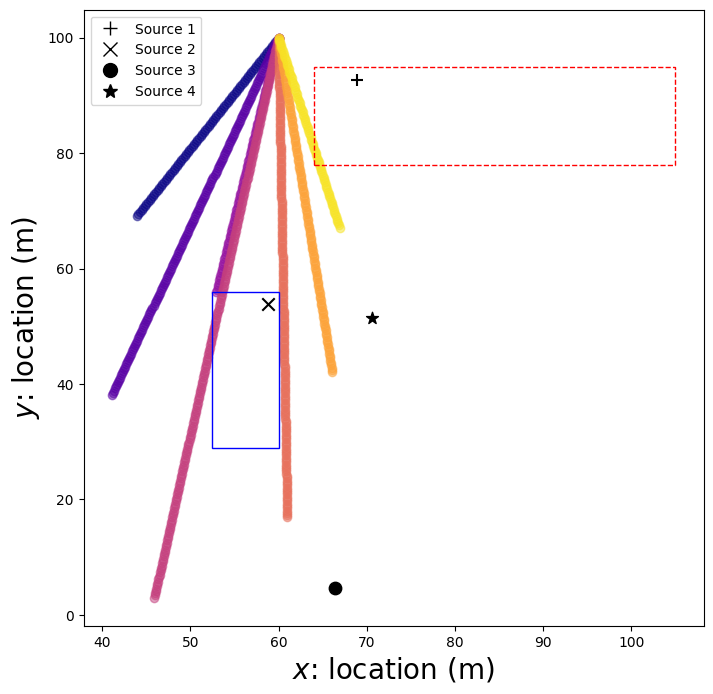

In [35]:
plt.figure(figsize=(8, 8))
plt.scatter(sources["source_1_location"][0], sources["source_1_location"][1], color='black', marker='+', label='Source 1', s=80)
plt.scatter(sources["source_2_location"][0], sources["source_2_location"][1], color='black', marker='x', label='Source 2', s=80)
plt.scatter(sources["source_3_location"][0], sources["source_3_location"][1], color='black', marker='o', label='Source 3', s=80)
plt.scatter(sources["source_4_location"][0], sources["source_4_location"][1], color='black', marker='*', label='Source 4', s=80)
plt.scatter(60, 100, color='lightcoral', marker='.')
colors = cm.plasma(np.linspace(0, 0.95, 7))

# Extract x, y, z coordinates
x_coords_1 = [location[0] for location in point_sensors_1_location]
y_coords_1 = [location[1] for location in point_sensors_1_location]

x_coords_2 = [location[0] for location in point_sensors_2_location]
y_coords_2 = [location[1] for location in point_sensors_2_location]

x_coords_3 = [location[0] for location in point_sensors_3_location]
y_coords_3 = [location[1] for location in point_sensors_3_location]

x_coords_4 = [location[0] for location in point_sensors_4_location]
y_coords_4 = [location[1] for location in point_sensors_4_location]

x_coords_5 = [location[0] for location in point_sensors_5_location]
y_coords_5 = [location[1] for location in point_sensors_5_location]

x_coords_6 = [location[0] for location in point_sensors_6_location]
y_coords_6 = [location[1] for location in point_sensors_6_location]

x_coords_7 = [location[0] for location in point_sensors_7_location]
y_coords_7 = [location[1] for location in point_sensors_7_location]


# Plot the sensor locations
plt.scatter(x_coords_1, y_coords_1, alpha=0.5, color=colors[0])
plt.scatter(x_coords_2, y_coords_2, alpha=0.5, color=colors[1])
plt.scatter(x_coords_3, y_coords_3, alpha=0.5, color=colors[2])
plt.scatter(x_coords_4, y_coords_4, alpha=0.5, color=colors[3])
plt.scatter(x_coords_5, y_coords_5, alpha=0.5, color=colors[4])
plt.scatter(x_coords_6, y_coords_6, alpha=0.5, color=colors[5])
plt.scatter(x_coords_7, y_coords_7, alpha=0.5, color=colors[6])
plt.xlabel("$x$: location (m)", fontsize=20)
plt.ylabel("$y$: location (m)", fontsize=20)
# Create a rectangle
rect_source1 = Rectangle((64, 78), 41, 17, linewidth=1, edgecolor='r', facecolor='none', linestyle='--')
rect_source2 = Rectangle((52.5, 29), 7.5, 27, linewidth=1, edgecolor='b', facecolor='none')
# Add the rectangle to the plot
plt.gca().add_patch(rect_source1)
plt.gca().add_patch(rect_source2)

plt.legend()
legend_elements = [ plt.Line2D([0], [0], marker='+', color='black', label='Source 1', markersize=10, linestyle='None'),
                    plt.Line2D([0], [0], marker='x', color='black', label='Source 2', markersize=10, linestyle='None'),
                    plt.Line2D([0], [0], marker='o', color='black', label='Source 3', markersize=10, linestyle='None'),
                    plt.Line2D([0], [0], marker='*', color='black', label='Source 4', markersize=10, linestyle='None')]

plt.legend(handles=legend_elements, loc='upper left')
# plt.savefig('sensor_and_source_location.pdf', dpi=300, bbox_inches='tight')
plt.show()

Box-whisker plots of Source 1 and Source 2 emission rate and location for all model tested.

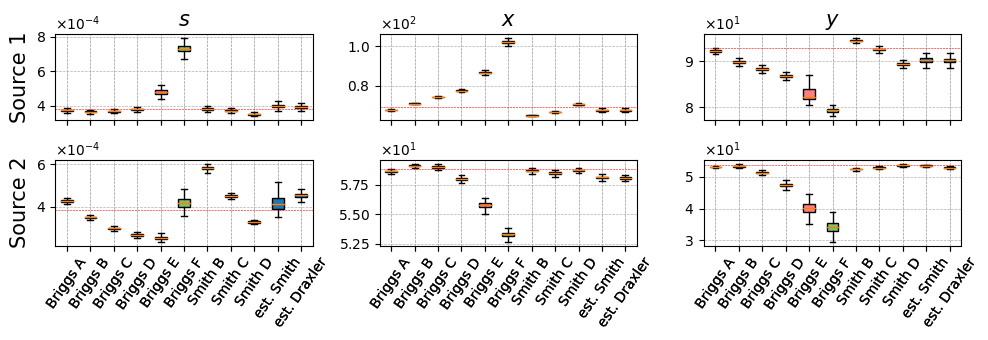

In [36]:
source_1_and_2 = [source_1_mcmc_chains, source_2_mcmc_chains]
plot_boxplots_chilbolton_sources(source_1_and_2, 4000, False)

<br><br><br>

## 5. Source 3 and Source 4 Results

The plots below show the lack of convergence when estimating the parameters for Source 3 and Source 4. We compare it to a Gaussian plume model simulation of Source 3 and Source 4 using the same Chilbolton source locations and the same sensor layout.

<div class="alert alert-block alert-info">
<b>DATA:</b> Need to replace data file paths with your own local path. The files are all located in the folder:<br>
Paper 1: Code/Data/Chilbolton_data_files/Postprocessed/Source_3_and_4/...
</div>

In [37]:
with open('/home/newmant1/PhD/Packages/Paper 1: Code/Data/Chilbolton_data_files/Postprocessed/Source_3_and_4/Chilbolton_CH4_measurements_source_3and4.pkl', 'rb') as f:
    observations_src3and4 = pickle.load(f)

with open('/home/newmant1/PhD/Packages/Paper 1: Code/Data/Chilbolton_data_files/Postprocessed/Source_3_and_4/Chilbolton_windfield_source_3and4.pkl', 'rb') as f:
    tangamma_ts_src3and4 = pickle.load(f)
    wind_field_src3and4 = tangamma_ts_src3and4[['Average Speed', 'Average Direction']]

In [38]:
# Source 1 location
source_location = gp.SourceLocation(
    source_location_x = jnp.array([sources["source_3_location"][0], sources["source_4_location"][0]]),
    source_location_y = jnp.array([sources["source_3_location"][1], sources["source_4_location"][1]]),
    source_location_z = jnp.array([sources["source_3_location"][2], sources["source_4_location"][2]]),
)


# Atmospheric State
atmospheric_state = gp.AtmosphericState(
    emission_rate = jnp.array([sources["source_3_emission_rate"], sources["source_4_emission_rate"]]),              
    source_half_width = jnp.array(1.0),                                 # Source is a square of 2m side length
    max_abl = jnp.array(1000.0),
    background_mean = None,                                  
    background_std = None,       
    background_seed = None,
    background_filter = None,        
    Gaussian_filter_kernel = None,              
    horizontal_opening_angle= None,
    vertical_opening_angle = None,
    a_horizontal = None,
    a_vertical = None,          
    b_horizontal = None,         
    b_vertical = None,        
)


# Gaussian Plume model
gaussianplume_src3and4 = gp.GaussianPlume(grid, source_location, wind_field_src3and4, atmospheric_state, sensors_settings)

fixed_src3and4  = gaussianplume_src3and4.fixed_objects_of_gridfree_chilbolton_coupling_matrix(simulation = False, wind_direction=wind_field_src3and4["Average Direction"].values, wind_speed=wind_field_src3and4["Average Speed"].values, tangamma_ts = tangamma_ts_src3and4, number_of_time_steps=wind_field_src3and4.shape[0])
fixed_ref1_src3and4 = fixed_src3and4[0], fixed_src3and4[7], fixed_src3and4[14], fixed_src3and4[15], fixed_src3and4[35], fixed_src3and4[36], fixed_src3and4[16], fixed_src3and4[37], fixed_src3and4[44]
fixed_ref2_src3and4 = fixed_src3and4[1], fixed_src3and4[8], fixed_src3and4[17], fixed_src3and4[18], fixed_src3and4[35], fixed_src3and4[36], fixed_src3and4[19], fixed_src3and4[38], fixed_src3and4[45]
fixed_ref3_src3and4 = fixed_src3and4[2], fixed_src3and4[9], fixed_src3and4[20], fixed_src3and4[21], fixed_src3and4[35], fixed_src3and4[36], fixed_src3and4[22], fixed_src3and4[39], fixed_src3and4[46]
fixed_ref4_src3and4 = fixed_src3and4[3], fixed_src3and4[10], fixed_src3and4[23], fixed_src3and4[24], fixed_src3and4[35], fixed_src3and4[36], fixed_src3and4[25], fixed_src3and4[40], fixed_src3and4[47]
fixed_ref5_src3and4 = fixed_src3and4[4], fixed_src3and4[11], fixed_src3and4[26], fixed_src3and4[27], fixed_src3and4[35], fixed_src3and4[36], fixed_src3and4[28], fixed_src3and4[41], fixed_src3and4[48]
fixed_ref6_src3and4 = fixed_src3and4[5], fixed_src3and4[12], fixed_src3and4[29], fixed_src3and4[30], fixed_src3and4[35], fixed_src3and4[36], fixed_src3and4[31], fixed_src3and4[42], fixed_src3and4[49]
fixed_ref7_src3and4 = fixed_src3and4[6], fixed_src3and4[13], fixed_src3and4[32], fixed_src3and4[33], fixed_src3and4[35], fixed_src3and4[36], fixed_src3and4[34], fixed_src3and4[43], fixed_src3and4[50]

### 5.1 Source 3 and Source 4 real Chilbolton data

#### 5.1.1 Loading the MCMC Chains

<div class="alert alert-block alert-info">
<b>DATA:</b> Need to replace data file paths with your own local path. The files are all located in the folder:<br>
Paper 1: Code/Data/MCMC_chains/Chilbolton_case_study/Source_3_and_4/...
</div>

In [95]:
with open('/home/newmant1/PhD/Packages/Paper 1: Code/Data/MCMC_chains/Chilbolton_case_study/Source_3_and_4/Estimated Draxler/Chilbolton_mcmc_chain_source_3and4_attempt1.pkl', 'rb') as f:
    est_Draxler_atmpt1 = pickle.load(f)

with open('/home/newmant1/PhD/Packages/Paper 1: Code/Data/MCMC_chains/Chilbolton_case_study/Source_3_and_4/Estimated Draxler/Chilbolton_mcmc_chain_source_3and4_attempt2.pkl', 'rb') as f:    
    est_Draxler_atmpt2 = pickle.load(f)


#### 5.1.2 Plotting the MCMC Chains

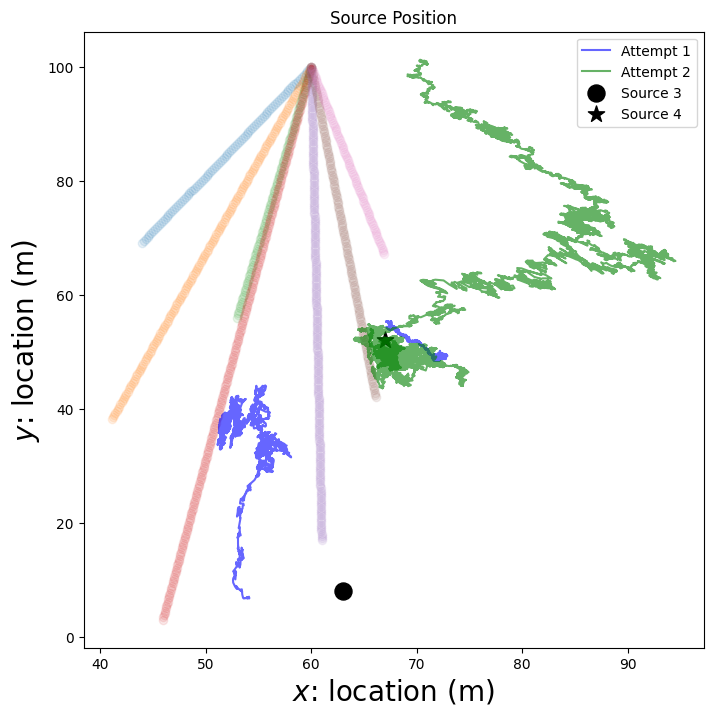

In [96]:
attempts = [est_Draxler_atmpt1, est_Draxler_atmpt2]
colors = ['b', 'g']
plt.figure(figsize=(8,8))
for i, attempt in enumerate(attempts):
    plt.plot(attempt["source_x"][:, 0], attempt["source_y"][:, 0], color=colors[i], alpha=0.6, label=f'Attempt {i+1}')
    plt.plot(attempt["source_x"][:, 1], attempt["source_y"][:, 1], color=colors[i], alpha=0.6)
plt.scatter(63, 8, color='black', marker='o', label='Source 3', s=150)
plt.scatter(67, 52, color='black', marker='*', label='Source 4', s=150)
plt.title("Source Position")
plt.scatter(60, 100, color='red', marker='.')

# Extract x, y, z coordinates
x_coords_1 = [location[0] for location in point_sensors_1_location]
y_coords_1 = [location[1] for location in point_sensors_1_location]

x_coords_2 = [location[0] for location in point_sensors_2_location]
y_coords_2 = [location[1] for location in point_sensors_2_location]

x_coords_3 = [location[0] for location in point_sensors_3_location]
y_coords_3 = [location[1] for location in point_sensors_3_location]

x_coords_4 = [location[0] for location in point_sensors_4_location]
y_coords_4 = [location[1] for location in point_sensors_4_location]

x_coords_5 = [location[0] for location in point_sensors_5_location]
y_coords_5 = [location[1] for location in point_sensors_5_location]

x_coords_6 = [location[0] for location in point_sensors_6_location]
y_coords_6 = [location[1] for location in point_sensors_6_location]

x_coords_7 = [location[0] for location in point_sensors_7_location]
y_coords_7 = [location[1] for location in point_sensors_7_location]


# Plot the sensor locations
plt.scatter(x_coords_1, y_coords_1, alpha=0.1)
plt.scatter(x_coords_2, y_coords_2, alpha=0.1)
plt.scatter(x_coords_3, y_coords_3, alpha=0.1)
plt.scatter(x_coords_4, y_coords_4, alpha=0.1)
plt.scatter(x_coords_5, y_coords_5, alpha=0.1)
plt.scatter(x_coords_6, y_coords_6, alpha=0.1)
plt.scatter(x_coords_7, y_coords_7, alpha=0.1)
plt.legend()
plt.xlabel("$x$: location (m)", fontsize=20)
plt.ylabel("$y$: location (m)", fontsize=20)
# plt.savefig('source_3_and_4_location_chains.png', dpi=300, bbox_inches='tight')
plt.show()

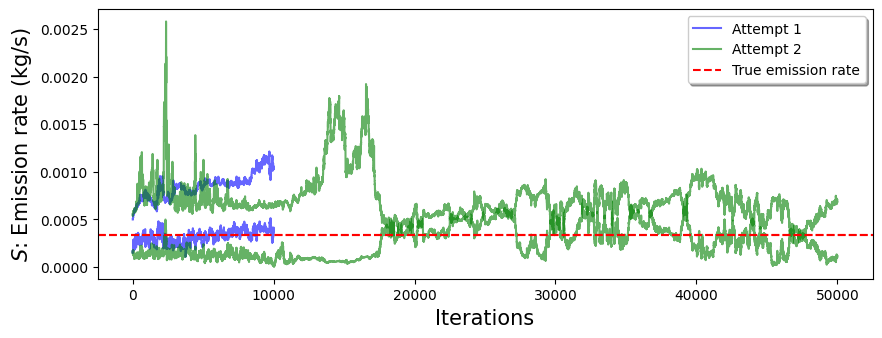

In [97]:
plt.figure(figsize=(10, 3.5))
for i, attempt in enumerate(attempts):
    plt.plot(attempt["s"][:, 0], color=colors[i], alpha=0.6, label=f'Attempt {i+1}')
    plt.plot(attempt["s"][:, 1], color=colors[i], alpha=0.6)
plt.axhline(sources["source_3_emission_rate"], color='r', linestyle='--', label='True emission rate')
plt.axhline(sources["source_4_emission_rate"], color='r', linestyle='--')
plt.legend(shadow=True, fancybox=True, fontsize=10)
plt.xlabel('Iterations', fontsize=15)
plt.ylabel('$S$: Emission rate (kg/s)', fontsize=15)
# plt.savefig('source_3_and_4_emission_rate.png', dpi=300, bbox_inches='tight')
plt.show()



### 5.2 Source 3 and Source 4 simulated Chilbolton data

#### 5.2.1 Loading the MCMC Chains

<div class="alert alert-block alert-info">
<b>DATA:</b> Need to replace data file paths with your own local path. The files are all located in the folder:<br>
Paper 1: Code/Data/MCMC_chains/Chilbolton_case_study/Chilbolton_simulations/...
</div>

In [105]:
with open('/home/newmant1/PhD/Packages/Paper 1: Code/Data/MCMC_chains/Chilbolton_case_study/Chilbolton_simulations/Chilbolton_mcmc_chain_source_3and4_simulation_attempt1.pkl', 'rb') as f:
    sim_atmpt1 = pickle.load(f)

with open('/home/newmant1/PhD/Packages/Paper 1: Code/Data/MCMC_chains/Chilbolton_case_study/Chilbolton_simulations/Chilbolton_mcmc_chain_source_3and4_simulation_attempt2.pkl', 'rb') as f:    
    sim_atmpt2 = pickle.load(f)

with open('/home/newmant1/PhD/Packages/Paper 1: Code/Data/MCMC_chains/Chilbolton_case_study/Chilbolton_simulations/Chilbolton_mcmc_chain_source_3and4_simulation_attempt3.pkl', 'rb') as f:    
    sim_atmpt3 = pickle.load(f)


#### 5.2.2 Plotting the MCMC Chains

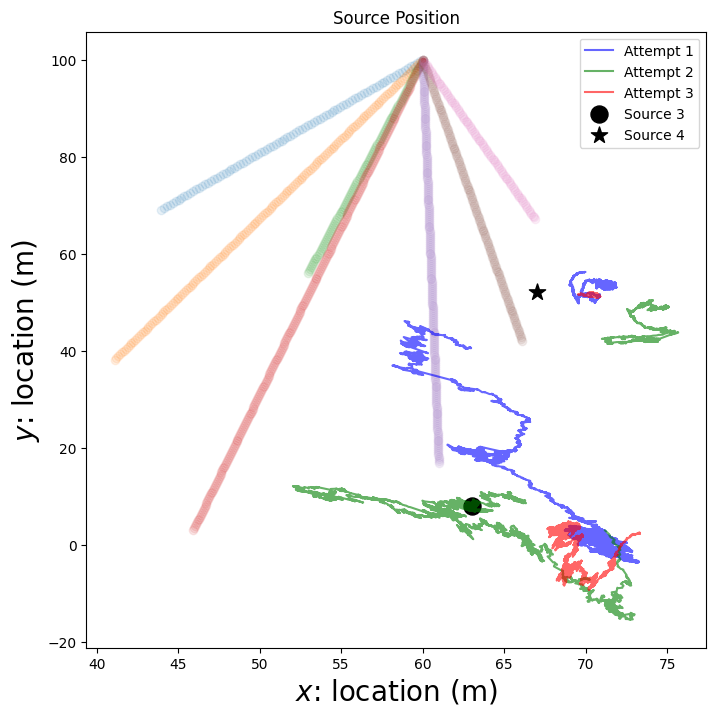

In [108]:
attempts = [sim_atmpt1, sim_atmpt2, sim_atmpt3]
colors = ['b', 'g', 'r', 'm']
plt.figure(figsize=(8,8))
for i, attempt in enumerate(attempts):
    plt.plot(attempt["source_x"][:, 0], attempt["source_y"][:, 0], color=colors[i], alpha=0.6, label=f'Attempt {i+1}')
    plt.plot(attempt["source_x"][:, 1], attempt["source_y"][:, 1], color=colors[i], alpha=0.6)
plt.scatter(63, 8, color='black', marker='o', label='Source 3', s=150)
plt.scatter(67, 52, color='black', marker='*', label='Source 4', s=150)
plt.title("Source Position")
plt.scatter(60, 100, color='red', marker='.')

# Extract x, y, z coordinates
x_coords_1 = [location[0] for location in point_sensors_1_location]
y_coords_1 = [location[1] for location in point_sensors_1_location]

x_coords_2 = [location[0] for location in point_sensors_2_location]
y_coords_2 = [location[1] for location in point_sensors_2_location]

x_coords_3 = [location[0] for location in point_sensors_3_location]
y_coords_3 = [location[1] for location in point_sensors_3_location]

x_coords_4 = [location[0] for location in point_sensors_4_location]
y_coords_4 = [location[1] for location in point_sensors_4_location]

x_coords_5 = [location[0] for location in point_sensors_5_location]
y_coords_5 = [location[1] for location in point_sensors_5_location]

x_coords_6 = [location[0] for location in point_sensors_6_location]
y_coords_6 = [location[1] for location in point_sensors_6_location]

x_coords_7 = [location[0] for location in point_sensors_7_location]
y_coords_7 = [location[1] for location in point_sensors_7_location]


# Plot the sensor locations
plt.scatter(x_coords_1, y_coords_1, alpha=0.1)
plt.scatter(x_coords_2, y_coords_2, alpha=0.1)
plt.scatter(x_coords_3, y_coords_3, alpha=0.1)
plt.scatter(x_coords_4, y_coords_4, alpha=0.1)
plt.scatter(x_coords_5, y_coords_5, alpha=0.1)
plt.scatter(x_coords_6, y_coords_6, alpha=0.1)
plt.scatter(x_coords_7, y_coords_7, alpha=0.1)
plt.legend()
plt.xlabel("$x$: location (m)", fontsize=20)
plt.ylabel("$y$: location (m)", fontsize=20)
# plt.savefig('simulation_source_3_and_4_location_chains.png', dpi=300, bbox_inches='tight')
plt.show()

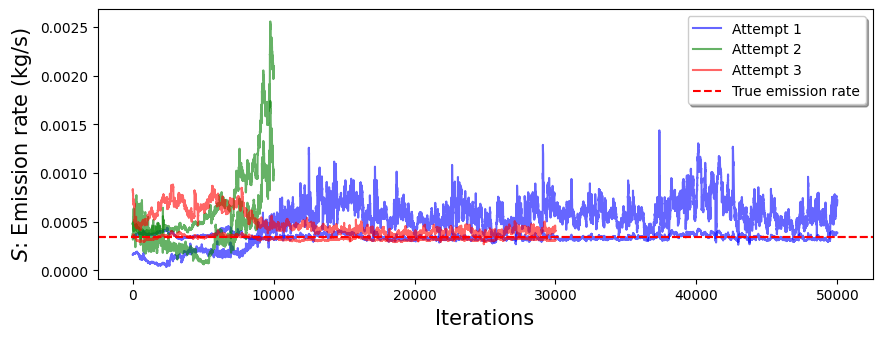

In [109]:
plt.figure(figsize=(10, 3.5))
for i, attempt in enumerate(attempts):
    plt.plot(attempt["s"][:, 0], color=colors[i], alpha=0.6, label=f'Attempt {i+1}')
    plt.plot(attempt["s"][:, 1], color=colors[i], alpha=0.6)
plt.axhline(sources["source_3_emission_rate"], color='r', linestyle='--', label='True emission rate')
plt.axhline(sources["source_4_emission_rate"], color='r', linestyle='--')
plt.legend(shadow=True, fancybox=True, fontsize=10)
plt.xlabel('Iterations', fontsize=15)
plt.ylabel('$S$: Emission rate (kg/s)', fontsize=15)
# plt.savefig('simulation_source_3_and_4_emission_rate.png', dpi=300, bbox_inches='tight')
plt.show()

